# Generative Adverserial Imitation Learning

Generative Adversarial Imitation Learning (GAIL) was first proposed in the paper [Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476) by Jonathan Ho and Stefano Ermon. 
The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

GAIL is based in the setting of reinforcement learning.
Reinforcment learning is an area of machine learning concerned with how agents take actions in an environment in order to maximize the sum of rewards.
So what a GAIL agent does is take actions in the bark environment and measure the resulting state of the agent and the world.

As the name says we are more specifically located in the setting of Imitation Learning. 
Our agent will try to learn a policy that mimics demonstrations.
We extract these demonstrations as Expert Trajectories from the interaction dataset by replaying the dataset in the bark simulator.
This gives us the expert rollouts which are a set of state action pairs representing the expert knowledge. 
In a RL setting, we need some sort of reward to update the agents network parameters.

In the GAIL approach we get the reward from an adversarial game:
Another discriminator network gets fed the agent rollouts and the experts rollouts and wants to classify between them accurately.
The agent network wants to fool the discriminator by minimizing the probability to get classified as fake.
The classification as fake or not that is output by the discriminator is the reward we feed into our agent network.
To minimize the classification as fake the agent network needs to mimic the experts demonstration and by doing so learn the experts policy.


<img width=70% src="files/data/gail_overview.gif">

## Project task

The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

### Port GAIL driver to bark
Do not reimplement gail, but use an existing implementation and bring it to bark.
We chose [TF2RL](https://github.com/keiohta/tf2rl).

### Train the GAIL agent on the Interaction Dataset
As a data source, we will use the interaction dataset: https://arxiv.org/abs/1910.03088 . Here,
w e are interested in the merging scenes: deu_merging_mt and chn_merging_zs
Have a look how the Interaction Dataset is integrated in bark: https://github.com/bark-
simulator/bark/blob/setup_tutorials/docs/tutorials/04_interaction_dataset.ipynb (NOte that
the dataset itsself is NOT enclosed with bark due to license limitations).
Train + validate agents individually for each scenes: In the first step, replace one agent and use
all other agents from the dataset: The gail agent navigates safely. Afterwards, replace more

### Evaluate the agent
Exchange the trained models on the German and the Chinese map: how well is the
generalization?
ONLY place gail agents on the map: Can we generate scenes that "look alike" the real scenarios?

## Interaction Dataset

## Expert Trajectories

## Generate Expert Trajectories

In [1]:
import os 
import bark
from pprint import pprint
from bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories import *

tracks_folder = os.path.join(os.getcwd(), 'data')
map_file = os.path.join(os.getcwd(), 'data/DR_DEU_Merging_MT_v01_shifted.xodr')
known_key = ('DR_DEU_Merging_MT_v01_shifted', 'vehicle_tracks_013')
ego_agent = 66

param_server = create_parameter_servers_for_scenarios(map_file, tracks_folder)[known_key]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["TrackIds"] = [
    63, 64, 65, 66, 67, 68]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["StartTs"] = 232000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EndTs"] = 259000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EgoTrackId"] = ego_agent

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


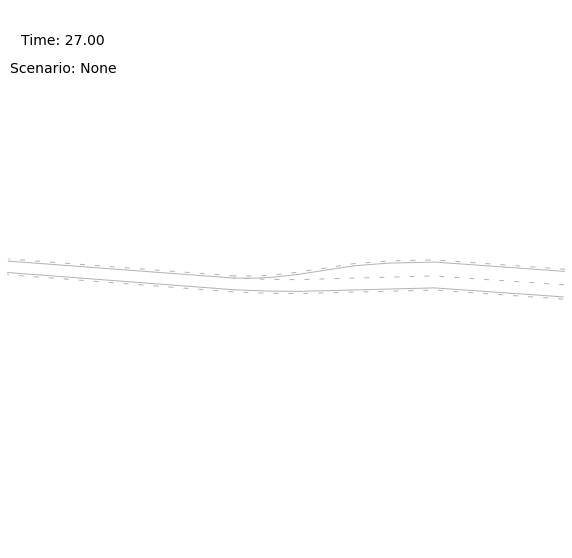

In [2]:
expert_trajectories = generate_expert_trajectories_for_scenario(param_server, sim_time_step=200, renderer="matplotlib_jupyter")

### The simulation gives us a number of observations and actions for the experts:

In [3]:
# Small number of observations for our agent
print(f'Observations for the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['obs'][:5])

Observations for the agent 66

[array([0.54990917, 0.55034685, 0.49115214, 0.02195392, 0.54979807,
       0.55021369, 0.48701411, 0.01664484, 0.55023372, 0.55031705,
       0.48717329, 0.01795783, 0.55020285, 0.55017918, 0.48908314,
       0.01927594]),
 array([0.5498873 , 0.5503481 , 0.49115214, 0.02188459, 0.54978162,
       0.55021507, 0.48701411, 0.0162844 , 0.5502159 , 0.55031848,
       0.48733243, 0.01776604, 0.55018389, 0.55018038, 0.48940146,
       0.0182608 ]),
 array([0.54986548, 0.55034935, 0.49099299, 0.02179474, 0.54976547,
       0.55021638, 0.48685497, 0.01594391, 0.55019826, 0.55031985,
       0.48733243, 0.01757585, 0.55016589, 0.55018145, 0.4895606 ,
       0.0172271 ]),
 array([0.54984373, 0.55035061, 0.49099299, 0.02165496, 0.54974967,
       0.55021775, 0.48685497, 0.01561338, 0.55018073, 0.55032122,
       0.48733243, 0.01744546, 0.55014902, 0.55018252, 0.48971975,
       0.01617412]),
 array([0.54982221, 0.55035186, 0.49083385, 0.02145529, 0.54973418,
       0.

In [4]:
# Small number of actions for our agent
print(f'Actions of the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['act'][:5])

Actions of the agent 66

[[0.0, -0.0003466568835577833],
 [-0.004201827340902073, -0.00030657489373432596],
 [0.002051691485158719, -0.00035168134700955115],
 [-0.004200119214675828, -0.0005815505374677107],
 [0.002049979741333098, -0.0009188447324507322]]


## GAIL implementation

### TF2RL implementation
We have chosen an off the shelf implementation, thelibrary [TF2RL](https://github.com/keiohta/tf2rl). It implements several reinforcement algorithms and training methods in [tensorflow 2](https://www.tensorflow.org/guide/effective_tf2). 

The GAIL agent is built up as follows:
* __Generator:__ A complete DDPG agent with the actor and critic networks. Both of them has 2-2 hidden layers.
* __Discriminator:__ A normal discriminator network with 2 hidden layers.

In this respect the agent is not in the traditional GAIL setup with 2 neural networks, but instead it actually has 5 networks, since the DDPG agent it self has got 4 of them for greater stability during training. The DDPG agent's critic network basically receives the judgement of the Discriminator network as the reward from the environment and its training aims to maximize this reward.

### Integration into BARK
The integration of the TF2RL based GAIL agent is done along existing BARK concepts and has been done in the following most important classes:
* __TF2RLWrapper:__ Wraps the BARK runtime to match the expectations of tf2rl about the environment. The observation and action normalization also takes place here.
    * file: `bark_ml/library_wrappers/lib_tf2rl/tf2rl_wrapper.py`
* __BehaviorTF2RLAgent:__ Base class for TF2RL based agents.
    * file: `bark_ml/library_wrappers/lib_tf2rl/agents/tf2rl_agent.py`
* __BehaviorGAILAgent:__ The TF2RL based GAIL agent.
    * file: `bark_ml/library_wrappers/lib_tf2rl/agents/gail_agent.py`
* __TF2RLRunner:__ Base class for TF2RL based runners.
    * file: `bark_ml/library_wrappers/lib_tf2rl/runners/tf2rl_runner.py`
* __GAILRunner:__ The TF2RL based GAIL runner.
    * file: `bark_ml/library_wrappers/lib_tf2rl/runners/gail_runner.py`
    
In the followings the training process is shown with visualization. Later the performance of a pre-trained agent is also shown through simulation.

---

### Training
The parameters which can be set on demand:
* The number of steps to train for.
* The frequency of testing and visualization during training
* The number of episodes to visualize during each testing round.

In [1]:
# Costumise some parameters here!!! #

gpu = 0                    # use -1 for cpu only.
max_steps = 10000          # Number of steps to train for.
test_interval = 1000       # test in every ... steps.
test_episodes = 5          # number of test episodes.
show_test_progress = False  # visualization during training.

In [2]:
# IMPORTS
import os
from pathlib import Path

# BARK imports
from bark_project.bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint, GailMergingBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf2rl.tf2rl_wrapper import TF2RLWrapper
from bark_ml.library_wrappers.lib_tf2rl.agents.gail_agent import BehaviorGAILAgent
from bark_ml.library_wrappers.lib_tf2rl.runners.gail_runner import GAILRunner
from bark_ml.library_wrappers.lib_tf2rl.load_expert_trajectories import load_expert_trajectories

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


/home/ferenc/.cache/bazel/_bazel_ferenc/d27c94d45ef586b197c709d8101d6384/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/commons/xodr_parser.py:108: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if lane.find("userData"):
20:36:49.711 [INFO] (trainer.py:65) Restored None
20:36:49.912 [INFO] (irl_trainer.py:74) Total Epi:     1 Steps:       2 Episode Steps:     2 Return: -1.0000 FPS: 10.88
20:37:48.193 [INFO] (irl_trainer.py:74) Total Epi:     2 Steps:       7 Episode Steps:     5 Return: -1.0000 FPS: 596.37
20:37:48.208 [INFO] (irl_trainer.py:74) Total Epi:     3 Steps:      17 Episode Steps:    10 Return: -1.0000 FPS: 729.83
20:37:48.214 [INFO] (irl_trainer.py:74) Total Epi:     4 Steps:      19 Episode Steps:     2 Return: -1.0000 FPS: 417.79
20:37:48.222 [INFO] (irl_trainer.py:74) Total Epi:     5 Steps:      23 Episode Steps:     4 Return: -1.000

20:37:49.041 [INFO] (irl_trainer.py:74) Total Epi:    66 Steps:     538 Episode Steps:     4 Return: -1.0000 FPS: 573.39
20:37:49.047 [INFO] (irl_trainer.py:74) Total Epi:    67 Steps:     540 Episode Steps:     2 Return: -1.0000 FPS: 422.62
20:37:49.054 [INFO] (irl_trainer.py:74) Total Epi:    68 Steps:     543 Episode Steps:     3 Return: -1.0000 FPS: 520.84
20:37:49.062 [INFO] (irl_trainer.py:74) Total Epi:    69 Steps:     547 Episode Steps:     4 Return: -1.0000 FPS: 582.30
20:37:49.078 [INFO] (irl_trainer.py:74) Total Epi:    70 Steps:     556 Episode Steps:     9 Return: -1.0000 FPS: 633.40
20:37:49.088 [INFO] (irl_trainer.py:74) Total Epi:    71 Steps:     562 Episode Steps:     6 Return: -1.0000 FPS: 672.31
20:37:49.117 [INFO] (irl_trainer.py:74) Total Epi:    72 Steps:     577 Episode Steps:    15 Return: -1.0000 FPS: 534.74
20:37:49.129 [INFO] (irl_trainer.py:74) Total Epi:    73 Steps:     584 Episode Steps:     7 Return: -1.0000 FPS: 659.76
20:37:49.137 [INFO] (irl_trainer

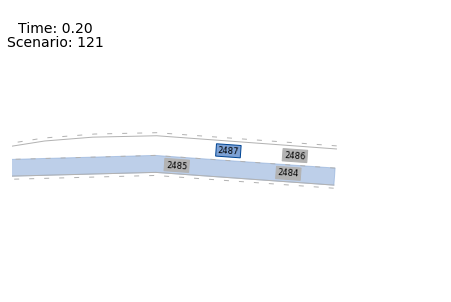

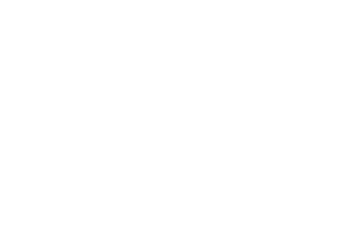

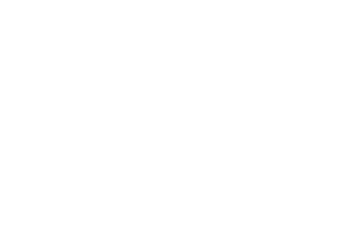

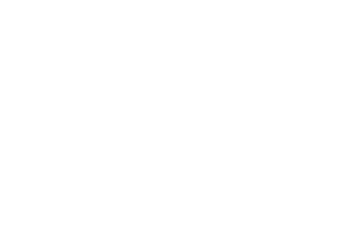

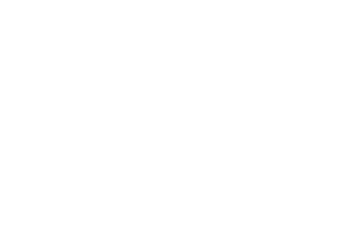

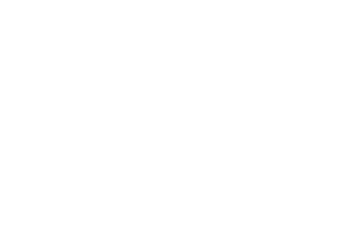

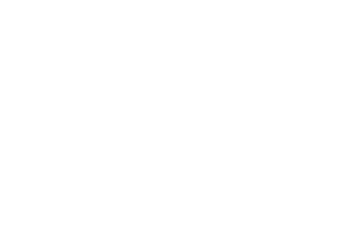

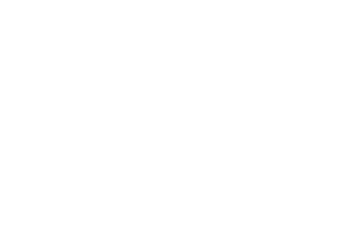

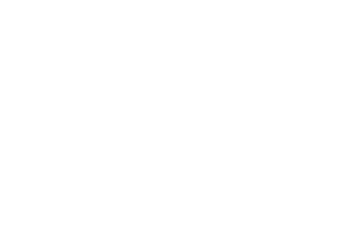

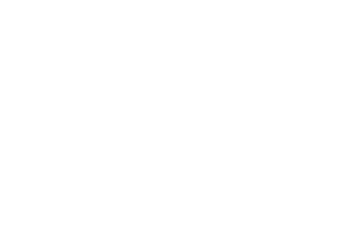

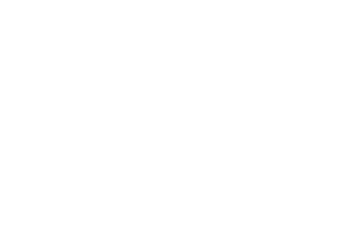

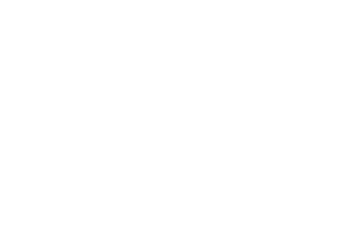

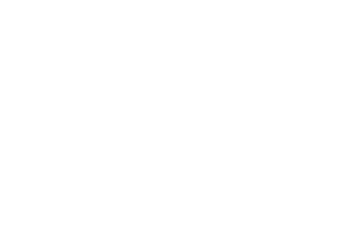

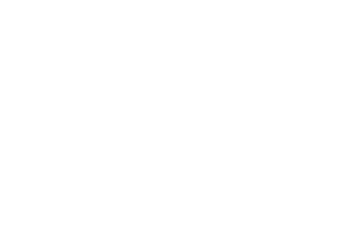

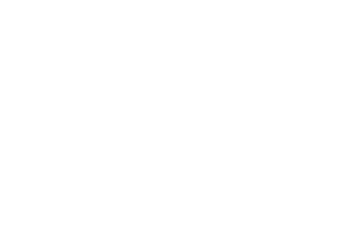

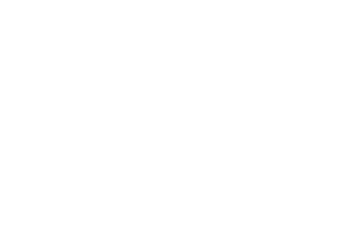

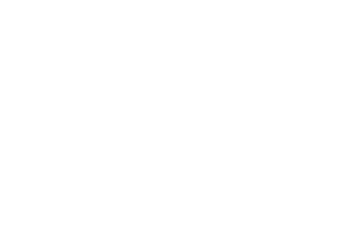

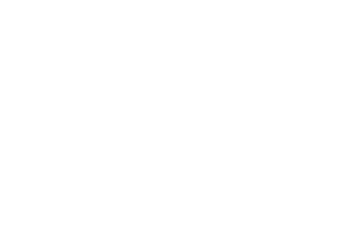

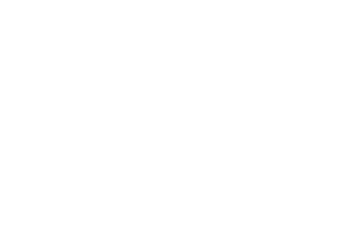

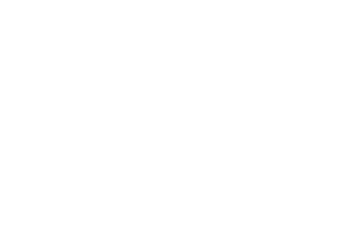

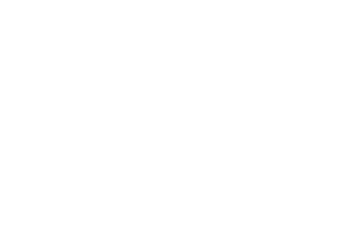

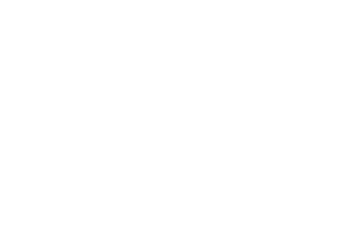

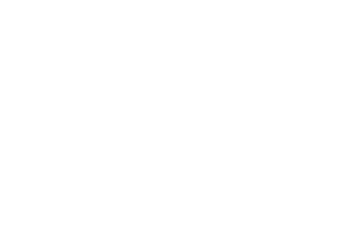

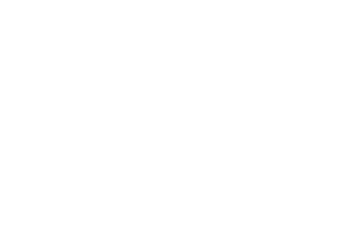

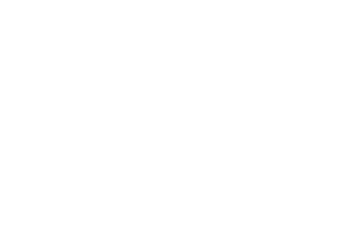

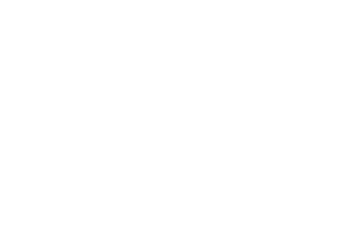

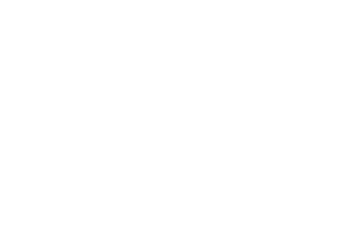

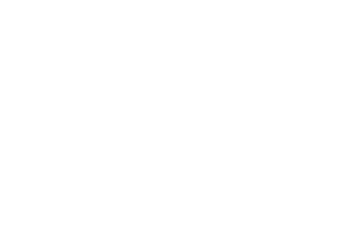

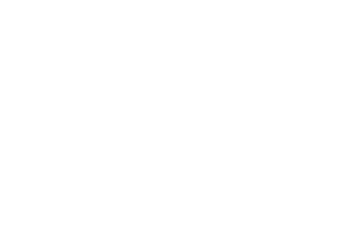

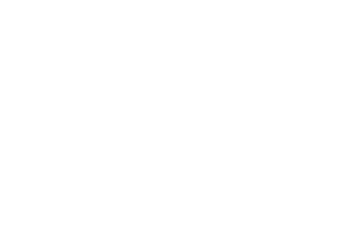

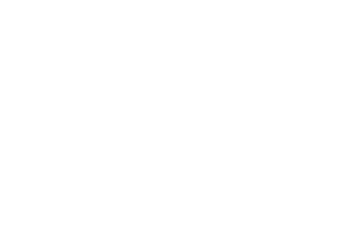

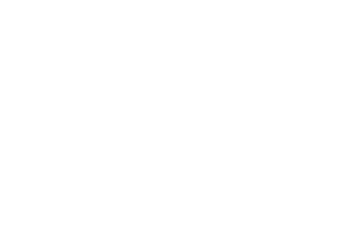

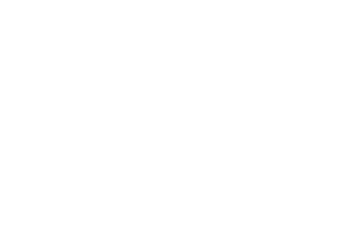

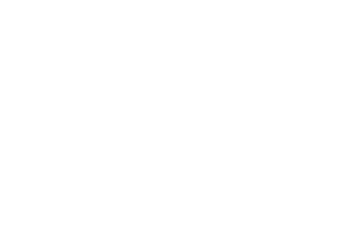

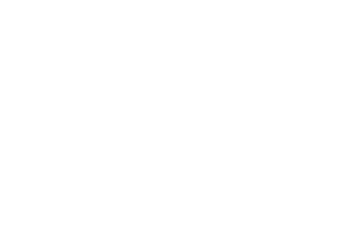

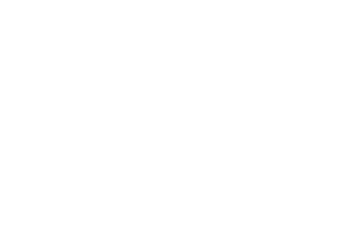

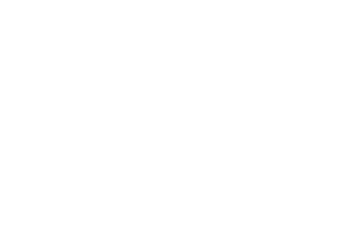

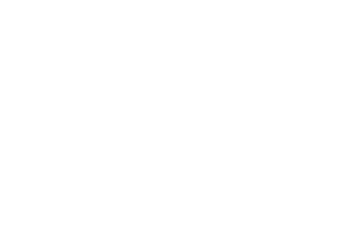

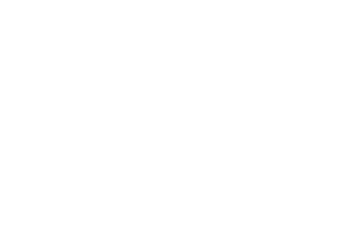

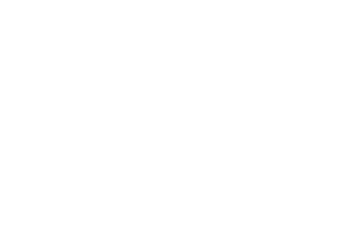

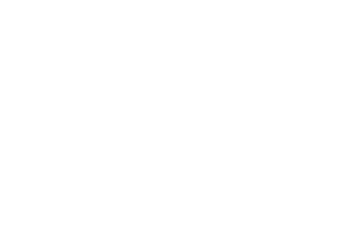

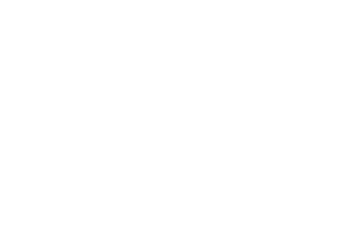

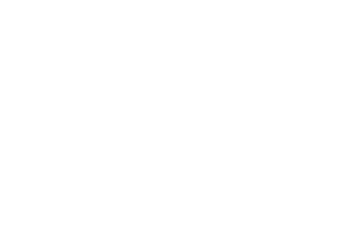

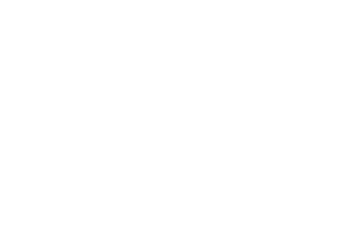

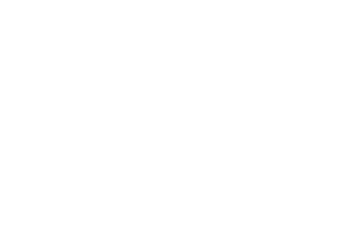

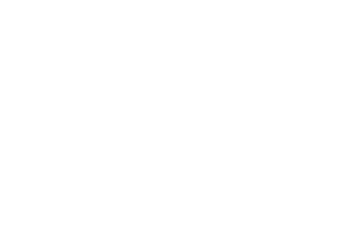

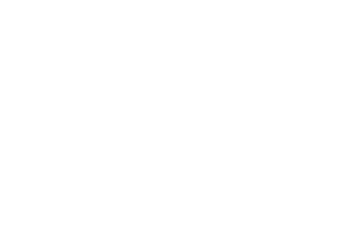

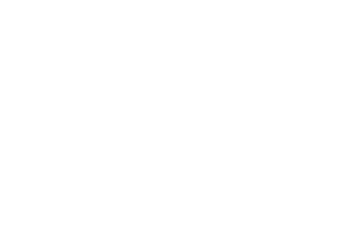

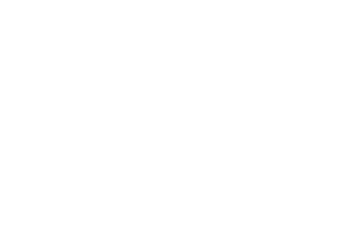

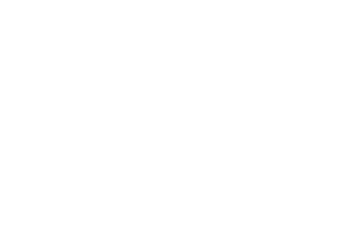

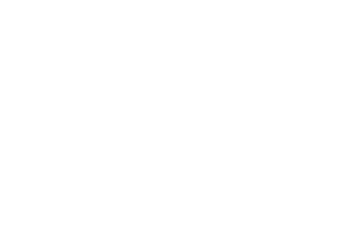

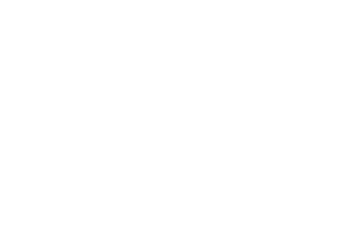

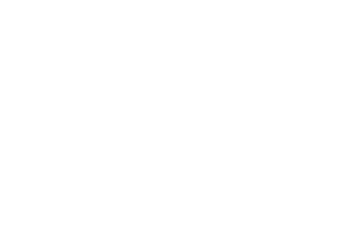

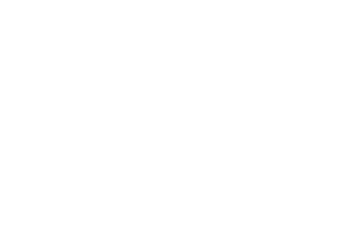

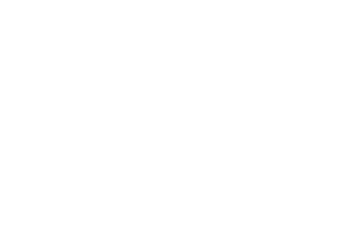

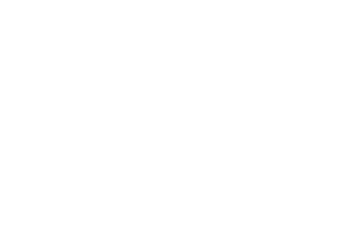

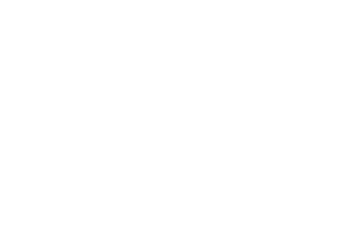

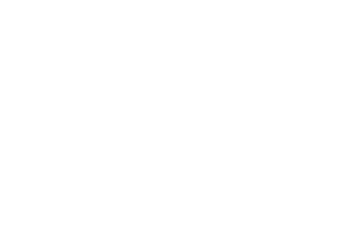

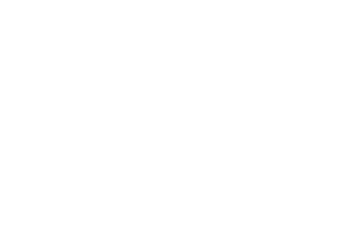

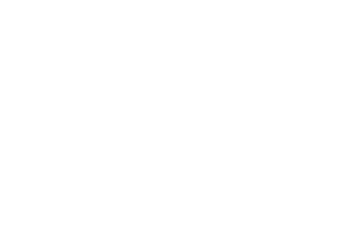

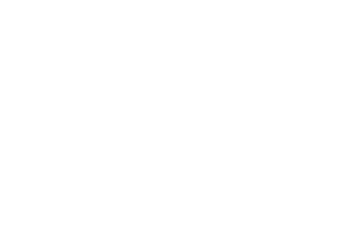

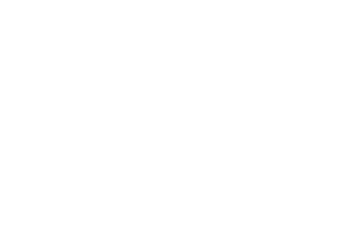

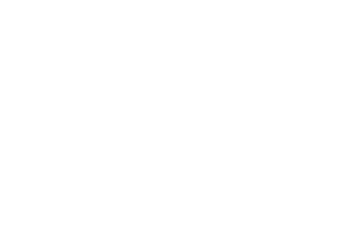

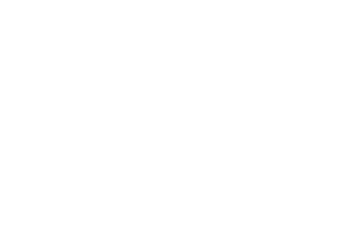

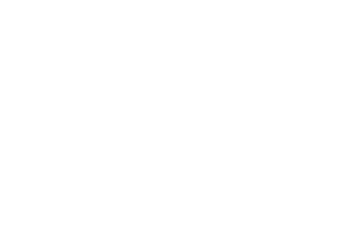

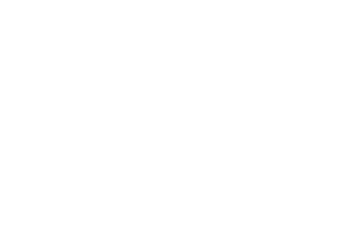

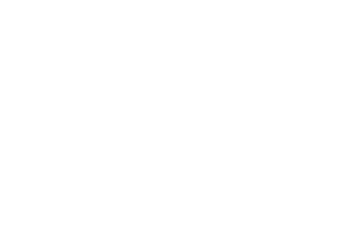

20:37:58.014 [INFO] (irl_trainer.py:119) Evaluation Total Steps:    1000 Average Reward -1.0000 / Average Step Count  13.4 over  5 episodes
20:37:58.049 [INFO] (irl_trainer.py:74) Total Epi:   121 Steps:    1001 Episode Steps:     4 Return: -1.0000 FPS:  0.48
20:37:58.125 [INFO] (irl_trainer.py:74) Total Epi:   122 Steps:    1006 Episode Steps:     5 Return: -1.0000 FPS: 66.41
20:37:58.182 [INFO] (irl_trainer.py:74) Total Epi:   123 Steps:    1010 Episode Steps:     4 Return: -1.0000 FPS: 72.18
20:37:58.241 [INFO] (irl_trainer.py:74) Total Epi:   124 Steps:    1014 Episode Steps:     4 Return: -1.0000 FPS: 69.05
20:37:58.296 [INFO] (irl_trainer.py:74) Total Epi:   125 Steps:    1017 Episode Steps:     3 Return: -1.0000 FPS: 57.55
20:37:58.357 [INFO] (irl_trainer.py:74) Total Epi:   126 Steps:    1021 Episode Steps:     4 Return: -1.0000 FPS: 67.29
20:37:58.451 [INFO] (irl_trainer.py:74) Total Epi:   127 Steps:    1027 Episode Steps:     6 Return: -1.0000 FPS: 65.32
20:37:58.550 [INFO] 

20:38:08.250 [INFO] (irl_trainer.py:74) Total Epi:   189 Steps:    1683 Episode Steps:    45 Return: -1.0000 FPS: 70.58
20:38:08.554 [INFO] (irl_trainer.py:74) Total Epi:   190 Steps:    1704 Episode Steps:    21 Return: -1.0000 FPS: 69.28
20:38:08.711 [INFO] (irl_trainer.py:74) Total Epi:   191 Steps:    1715 Episode Steps:    11 Return: -1.0000 FPS: 71.46
20:38:08.978 [INFO] (irl_trainer.py:74) Total Epi:   192 Steps:    1733 Episode Steps:    18 Return: -1.0000 FPS: 67.82
20:38:09.041 [INFO] (irl_trainer.py:74) Total Epi:   193 Steps:    1737 Episode Steps:     4 Return: -1.0000 FPS: 64.51
20:38:09.200 [INFO] (irl_trainer.py:74) Total Epi:   194 Steps:    1748 Episode Steps:    11 Return: -1.0000 FPS: 69.74
20:38:09.361 [INFO] (irl_trainer.py:74) Total Epi:   195 Steps:    1759 Episode Steps:    11 Return: -1.0000 FPS: 69.06
20:38:09.419 [INFO] (irl_trainer.py:74) Total Epi:   196 Steps:    1763 Episode Steps:     4 Return: -1.0000 FPS: 70.76
20:38:09.613 [INFO] (irl_trainer.py:74) 

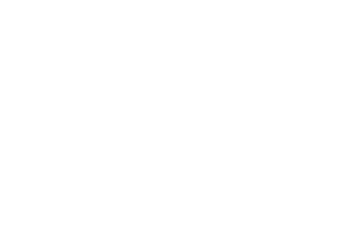

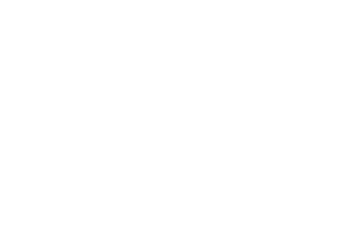

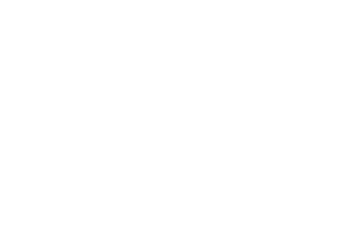

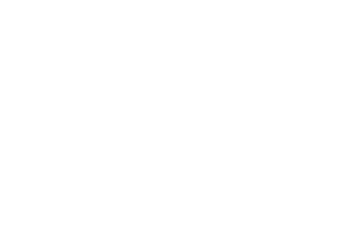

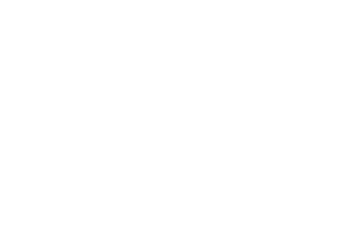

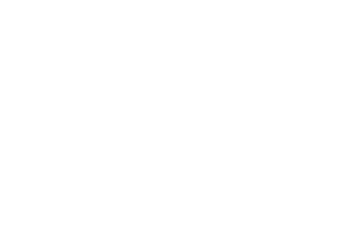

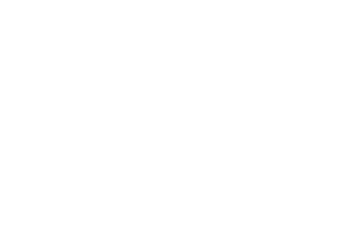

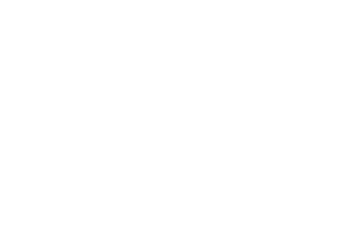

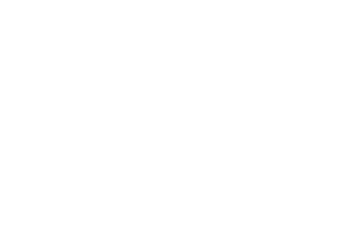

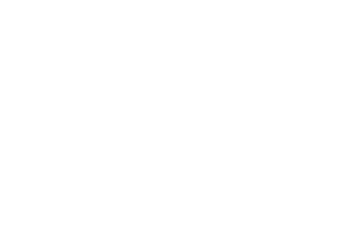

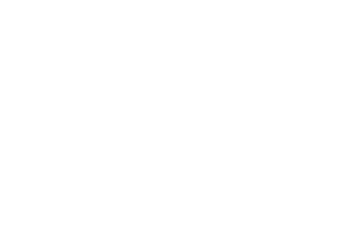

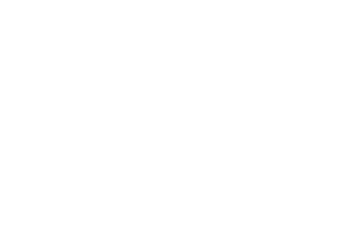

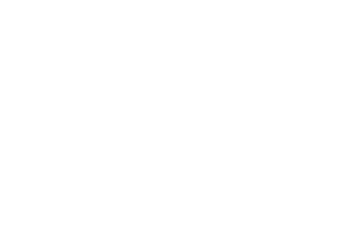

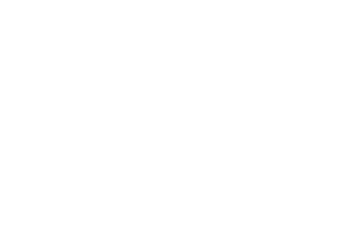

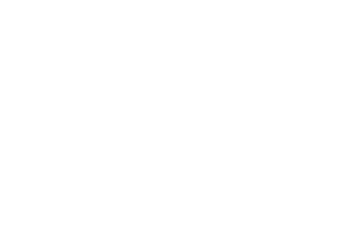

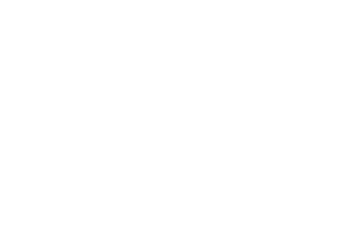

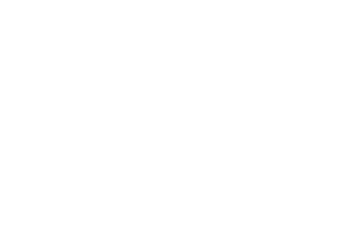

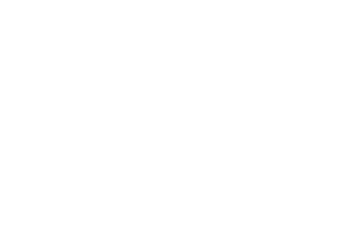

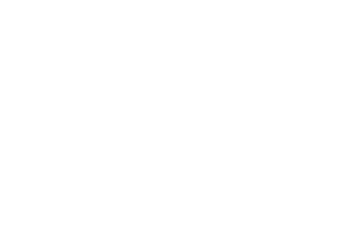

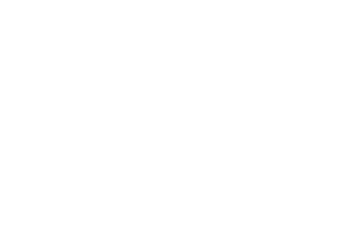

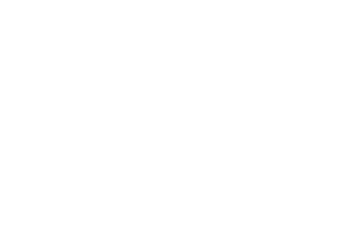

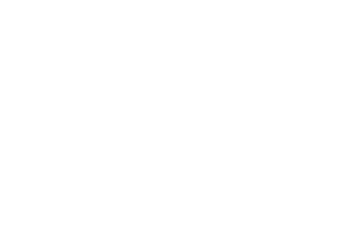

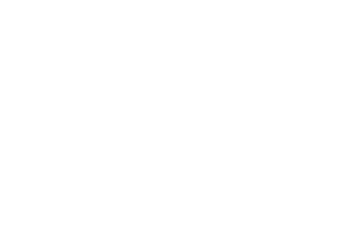

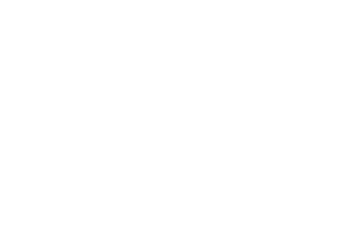

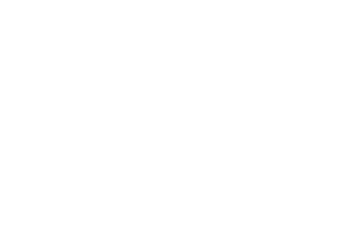

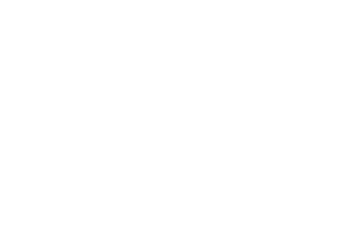

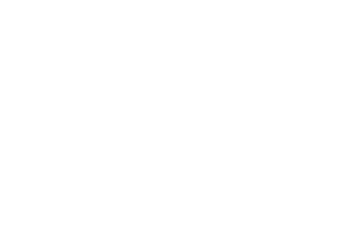

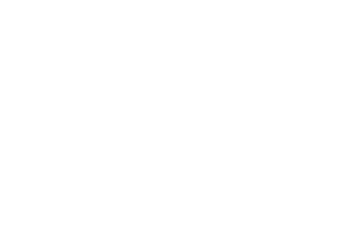

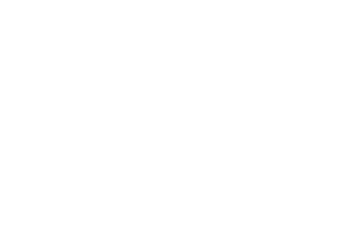

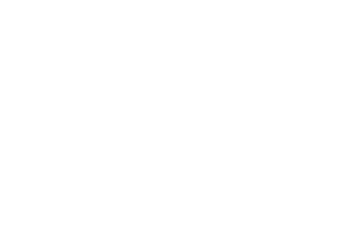

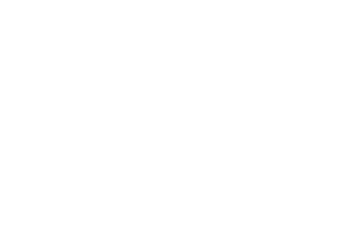

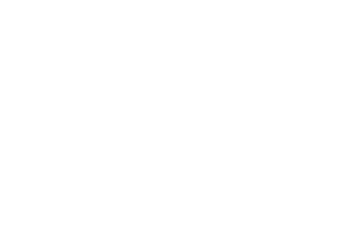

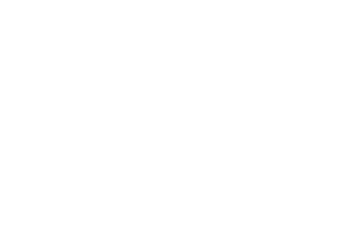

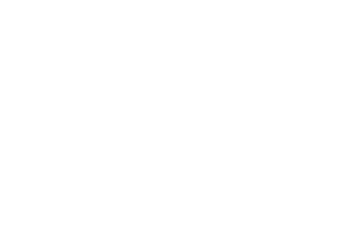

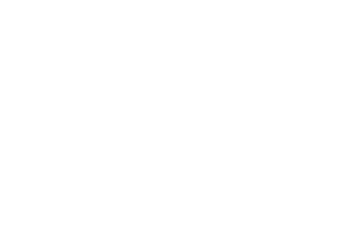

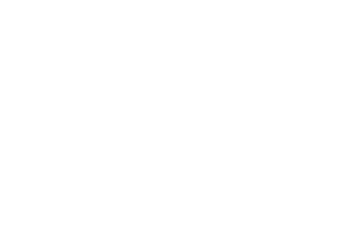

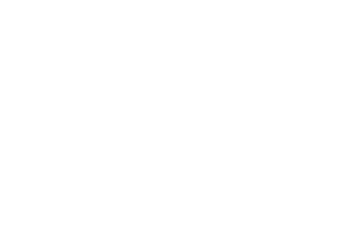

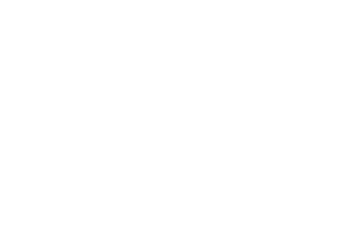

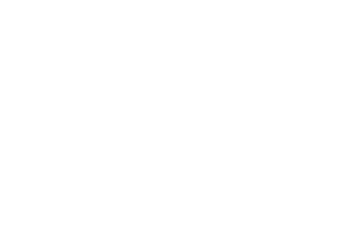

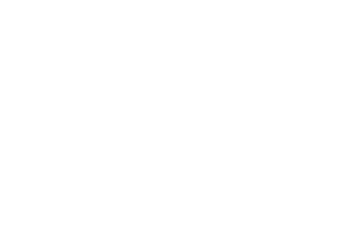

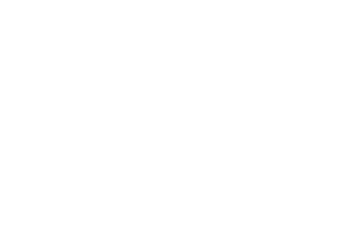

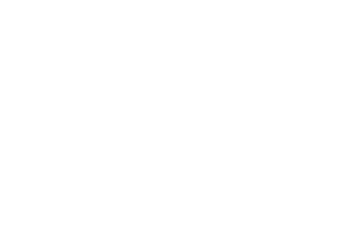

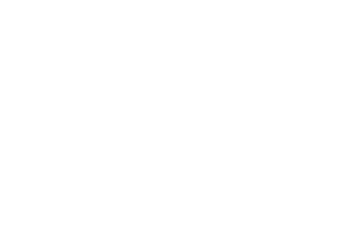

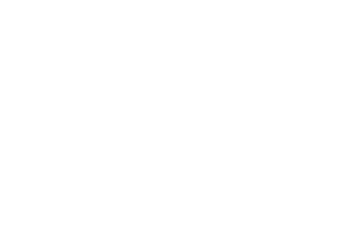

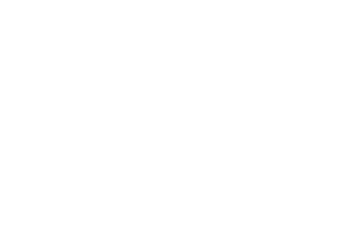

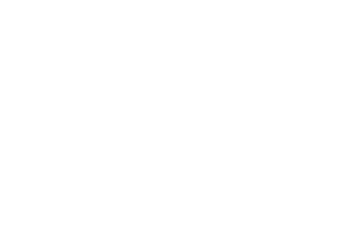

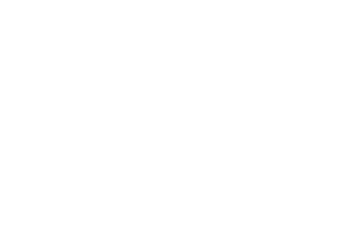

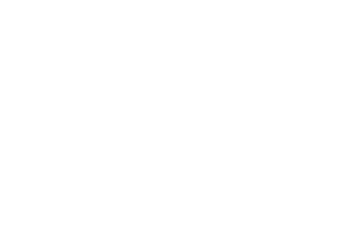

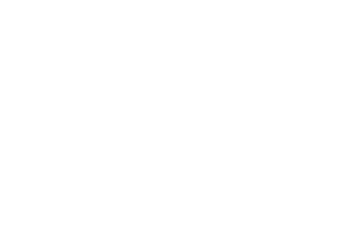

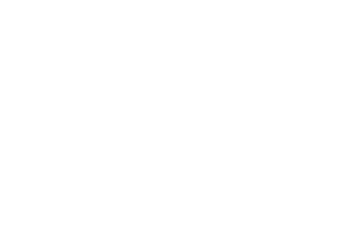

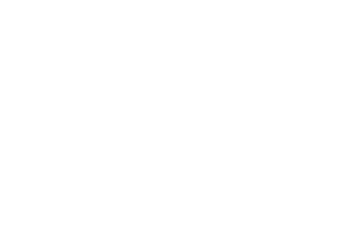

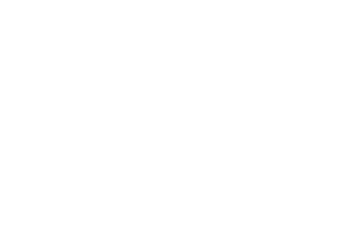

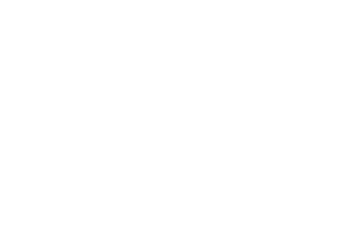

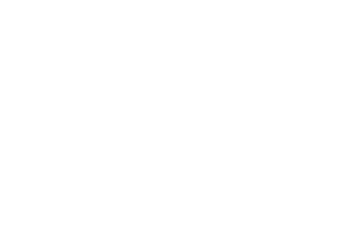

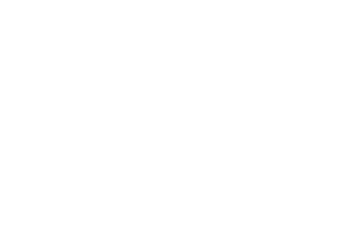

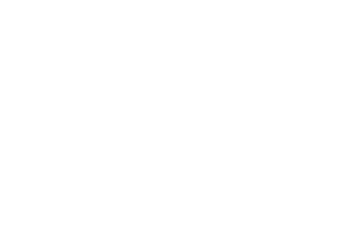

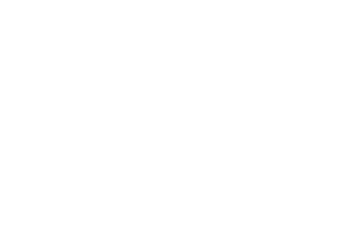

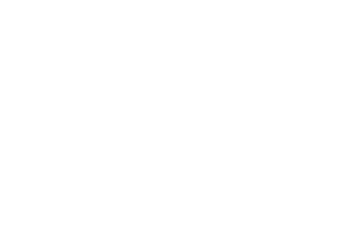

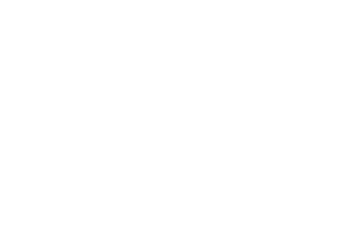

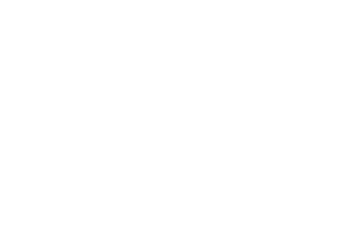

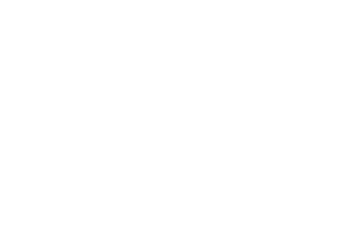

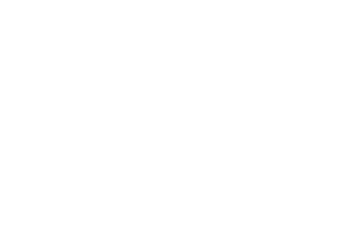

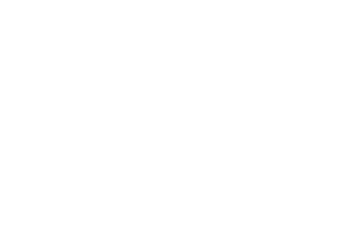

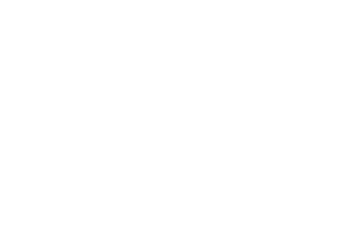

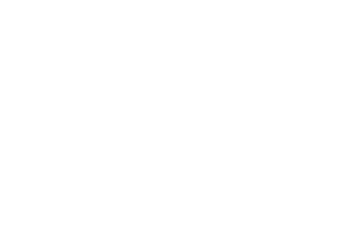

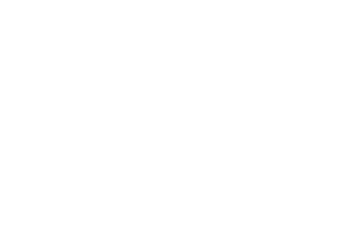

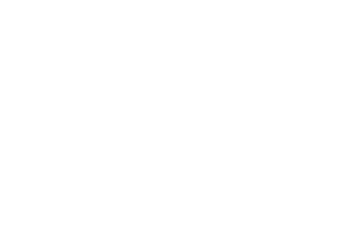

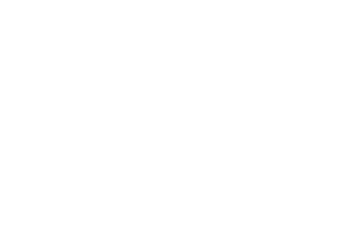

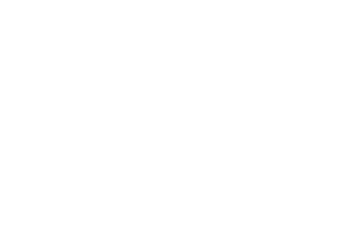

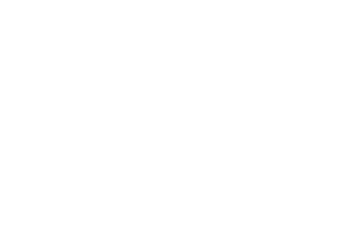

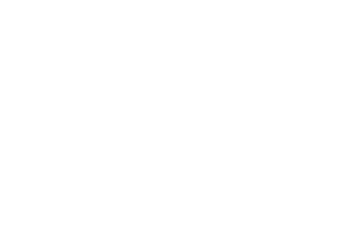

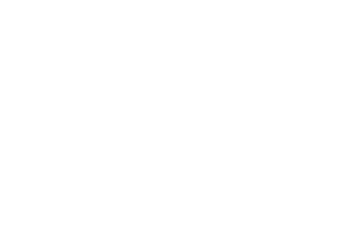

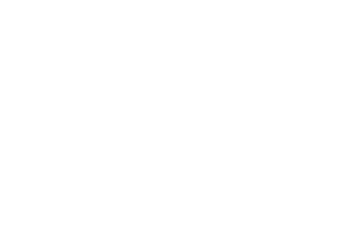

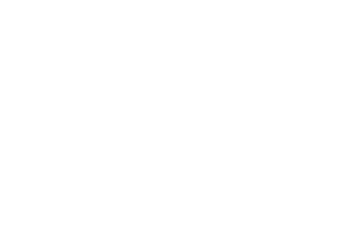

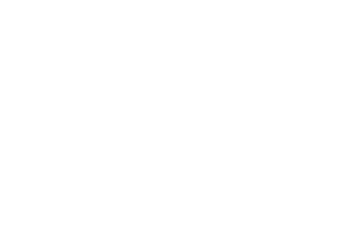

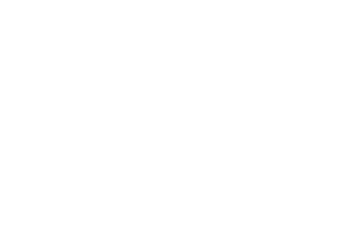

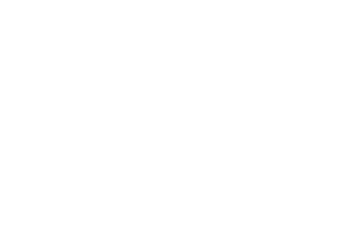

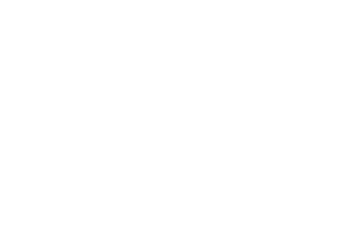

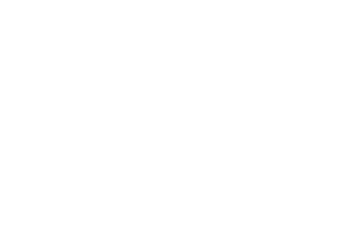

20:38:19.661 [INFO] (irl_trainer.py:119) Evaluation Total Steps:    2000 Average Reward -0.6000 / Average Step Count  15.8 over  5 episodes
20:38:19.668 [INFO] (irl_trainer.py:74) Total Epi:   217 Steps:    2001 Episode Steps:    20 Return: -1.0000 FPS:  2.91
20:38:19.907 [INFO] (irl_trainer.py:74) Total Epi:   218 Steps:    2014 Episode Steps:    13 Return: -1.0000 FPS: 54.87
20:38:20.078 [INFO] (irl_trainer.py:74) Total Epi:   219 Steps:    2021 Episode Steps:     7 Return: -1.0000 FPS: 41.38
20:38:20.286 [INFO] (irl_trainer.py:74) Total Epi:   220 Steps:    2034 Episode Steps:    13 Return: -1.0000 FPS: 63.05
20:38:20.436 [INFO] (irl_trainer.py:74) Total Epi:   221 Steps:    2044 Episode Steps:    10 Return: -1.0000 FPS: 67.28
20:38:20.657 [INFO] (irl_trainer.py:74) Total Epi:   222 Steps:    2058 Episode Steps:    14 Return: -1.0000 FPS: 63.98
20:38:20.862 [INFO] (irl_trainer.py:74) Total Epi:   223 Steps:    2072 Episode Steps:    14 Return: -1.0000 FPS: 68.65
20:38:21.057 [INFO] 

20:38:29.525 [INFO] (irl_trainer.py:74) Total Epi:   285 Steps:    2673 Episode Steps:     9 Return: -1.0000 FPS: 75.89
20:38:29.633 [INFO] (irl_trainer.py:74) Total Epi:   286 Steps:    2681 Episode Steps:     8 Return: -1.0000 FPS: 75.64
20:38:29.951 [INFO] (irl_trainer.py:74) Total Epi:   287 Steps:    2703 Episode Steps:    22 Return:  1.0000 FPS: 69.45
20:38:30.171 [INFO] (irl_trainer.py:74) Total Epi:   288 Steps:    2719 Episode Steps:    16 Return: -1.0000 FPS: 73.06
20:38:30.252 [INFO] (irl_trainer.py:74) Total Epi:   289 Steps:    2724 Episode Steps:     5 Return: -1.0000 FPS: 62.83
20:38:30.484 [INFO] (irl_trainer.py:74) Total Epi:   290 Steps:    2741 Episode Steps:    17 Return: -1.0000 FPS: 73.82
20:38:31.081 [INFO] (irl_trainer.py:74) Total Epi:   291 Steps:    2785 Episode Steps:    44 Return: -1.0000 FPS: 73.78
20:38:31.155 [INFO] (irl_trainer.py:74) Total Epi:   292 Steps:    2790 Episode Steps:     5 Return: -1.0000 FPS: 68.87
20:38:31.273 [INFO] (irl_trainer.py:74) 

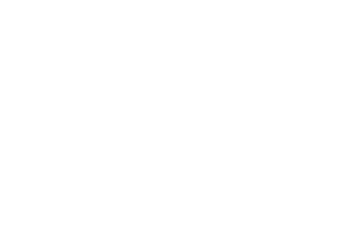

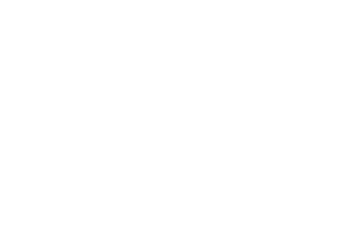

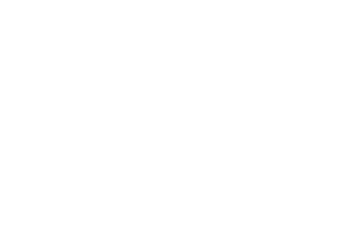

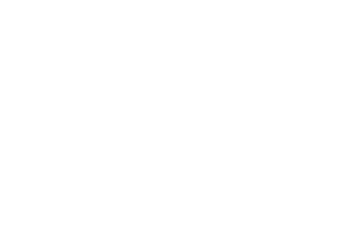

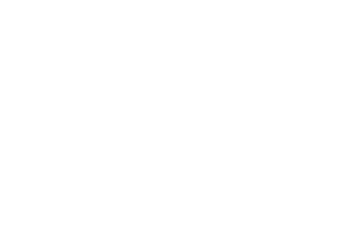

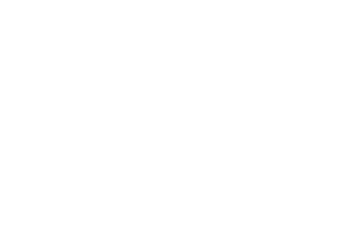

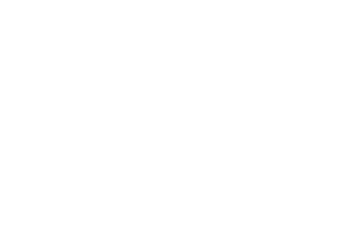

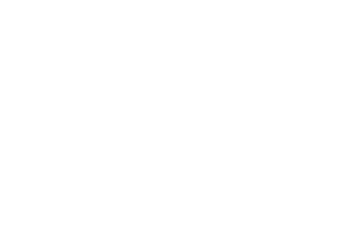

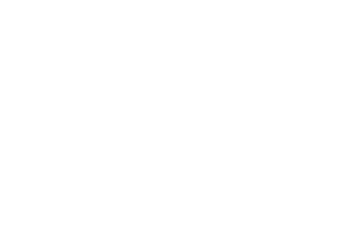

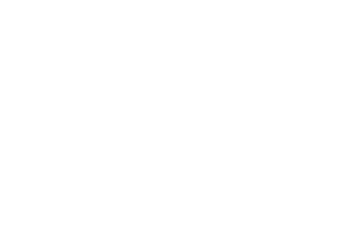

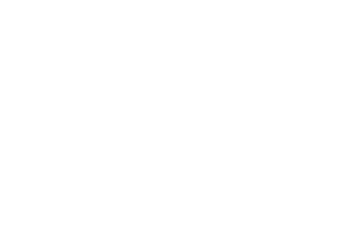

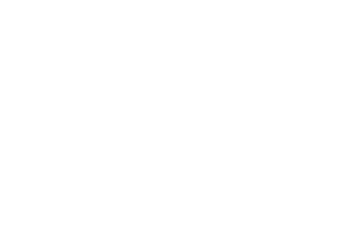

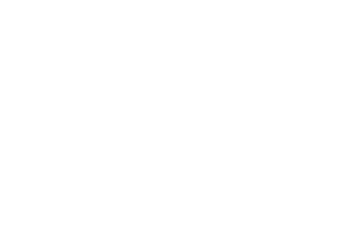

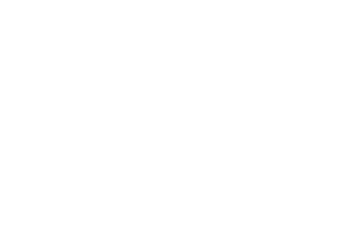

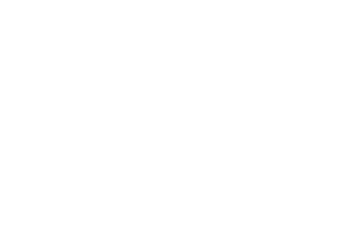

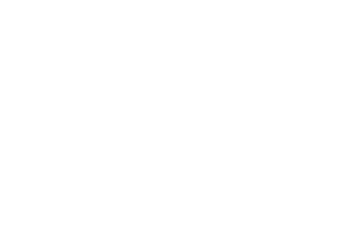

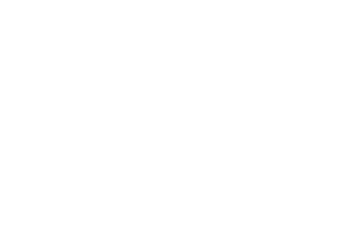

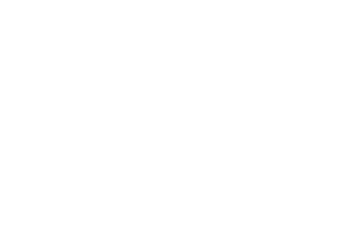

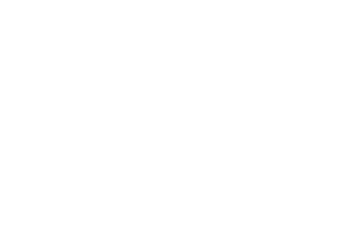

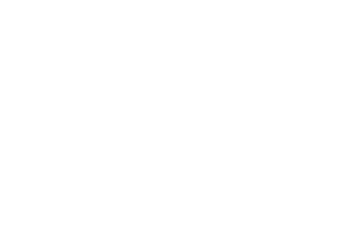

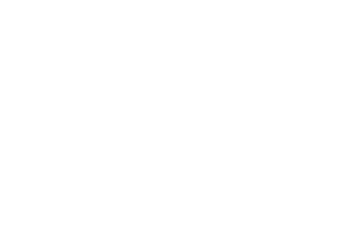

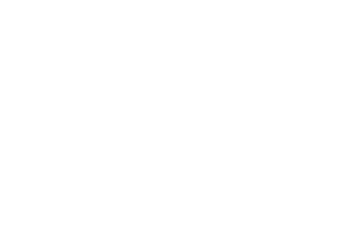

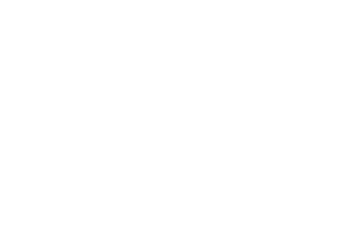

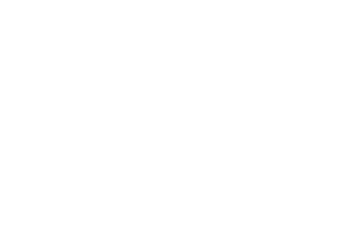

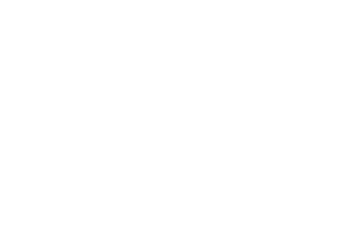

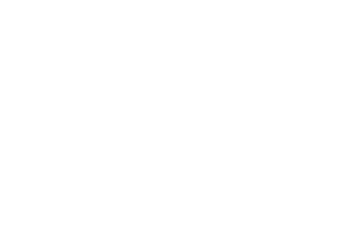

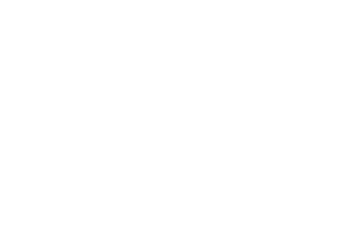

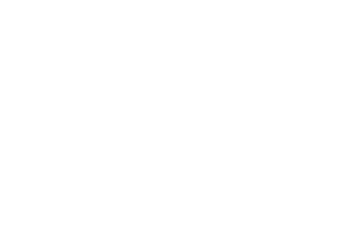

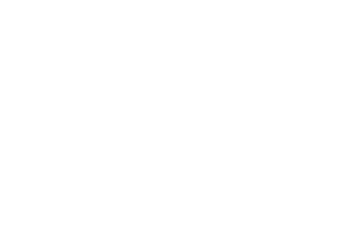

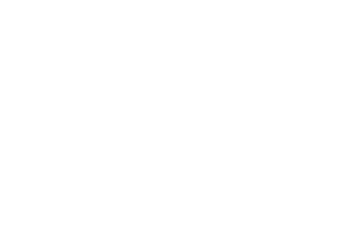

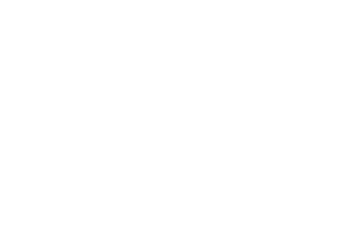

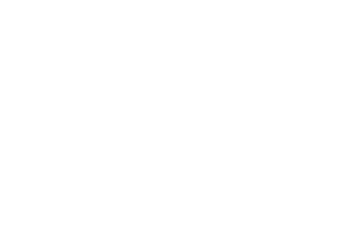

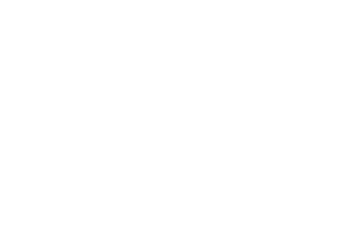

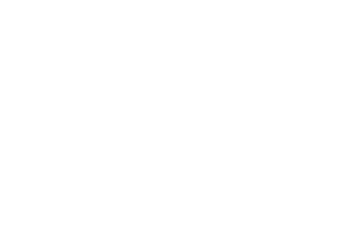

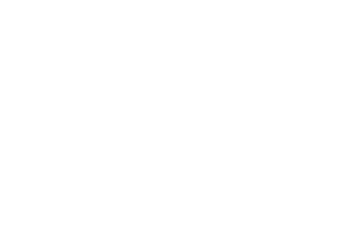

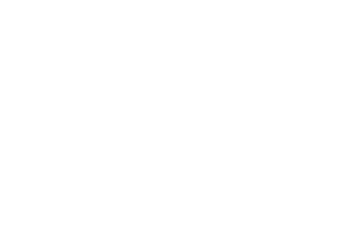

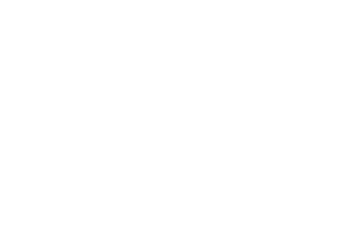

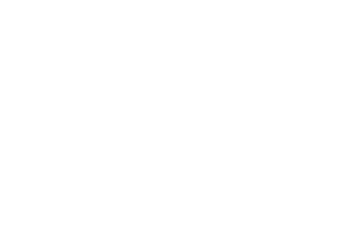

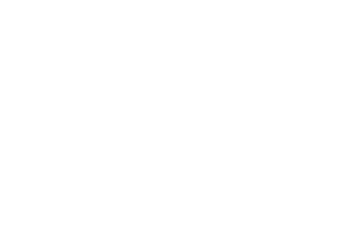

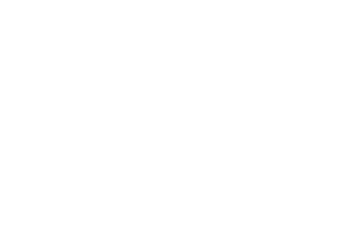

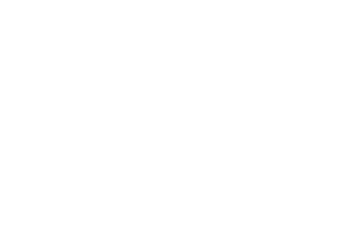

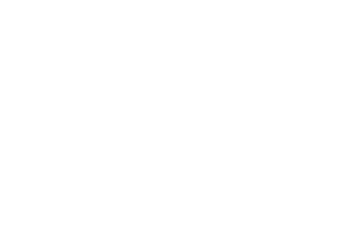

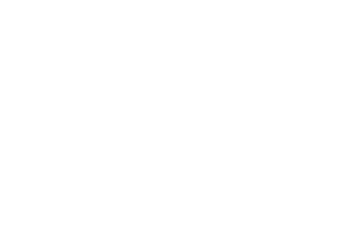

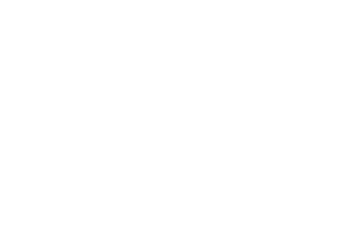

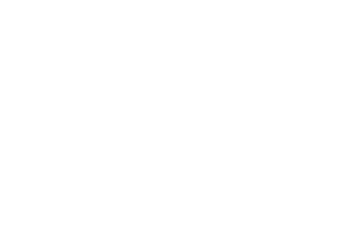

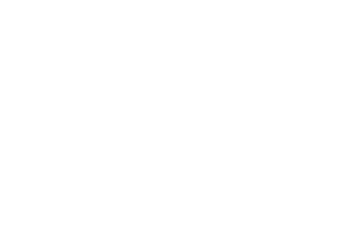

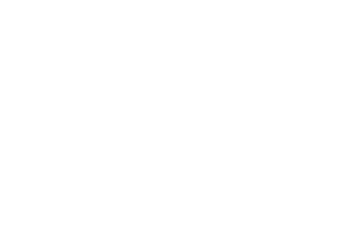

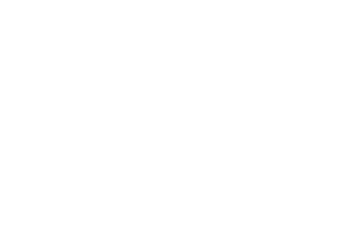

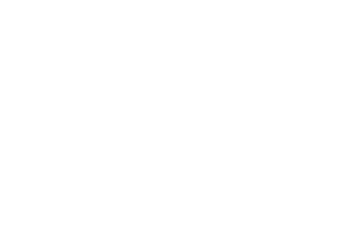

20:38:38.309 [INFO] (irl_trainer.py:119) Evaluation Total Steps:    3000 Average Reward -1.0000 / Average Step Count  9.8 over  5 episodes
20:38:38.316 [INFO] (irl_trainer.py:74) Total Epi:   315 Steps:    3001 Episode Steps:     2 Return: -1.0000 FPS:  0.48
20:38:38.389 [INFO] (irl_trainer.py:74) Total Epi:   316 Steps:    3006 Episode Steps:     5 Return: -1.0000 FPS: 69.59
20:38:38.496 [INFO] (irl_trainer.py:74) Total Epi:   317 Steps:    3013 Episode Steps:     7 Return: -1.0000 FPS: 66.59
20:38:38.702 [INFO] (irl_trainer.py:74) Total Epi:   318 Steps:    3027 Episode Steps:    14 Return: -1.0000 FPS: 68.48
20:38:38.901 [INFO] (irl_trainer.py:74) Total Epi:   319 Steps:    3041 Episode Steps:    14 Return: -1.0000 FPS: 70.92
20:38:39.099 [INFO] (irl_trainer.py:74) Total Epi:   320 Steps:    3055 Episode Steps:    14 Return:  1.0000 FPS: 71.12
20:38:39.197 [INFO] (irl_trainer.py:74) Total Epi:   321 Steps:    3061 Episode Steps:     6 Return: -1.0000 FPS: 62.50
20:38:39.255 [INFO] (

20:38:48.670 [INFO] (irl_trainer.py:74) Total Epi:   383 Steps:    3645 Episode Steps:     8 Return: -1.0000 FPS: 67.47
20:38:48.781 [INFO] (irl_trainer.py:74) Total Epi:   384 Steps:    3653 Episode Steps:     8 Return: -1.0000 FPS: 72.81
20:38:48.870 [INFO] (irl_trainer.py:74) Total Epi:   385 Steps:    3659 Episode Steps:     6 Return: -1.0000 FPS: 68.64
20:38:49.063 [INFO] (irl_trainer.py:74) Total Epi:   386 Steps:    3673 Episode Steps:    14 Return:  1.0000 FPS: 73.31
20:38:49.271 [INFO] (irl_trainer.py:74) Total Epi:   387 Steps:    3688 Episode Steps:    15 Return:  1.0000 FPS: 72.32
20:38:49.372 [INFO] (irl_trainer.py:74) Total Epi:   388 Steps:    3695 Episode Steps:     7 Return: -1.0000 FPS: 70.48
20:38:49.443 [INFO] (irl_trainer.py:74) Total Epi:   389 Steps:    3700 Episode Steps:     5 Return: -1.0000 FPS: 72.53
20:38:49.519 [INFO] (irl_trainer.py:74) Total Epi:   390 Steps:    3704 Episode Steps:     4 Return: -1.0000 FPS: 53.43
20:38:49.623 [INFO] (irl_trainer.py:74) 

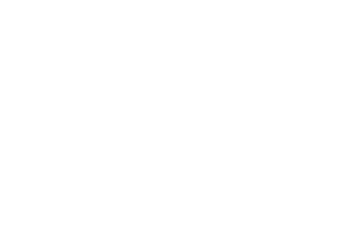

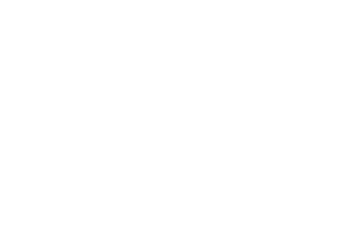

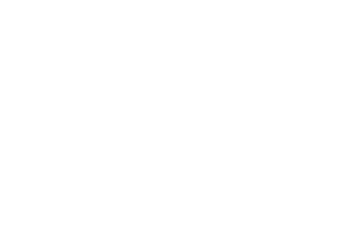

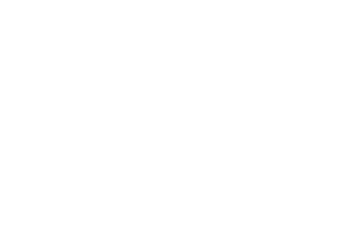

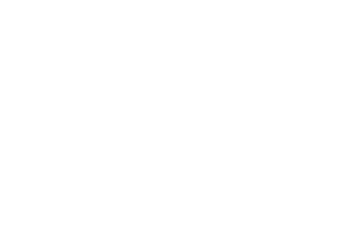

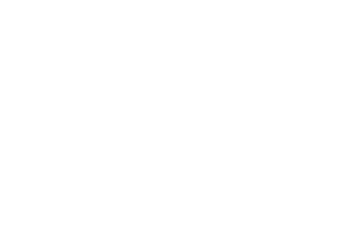

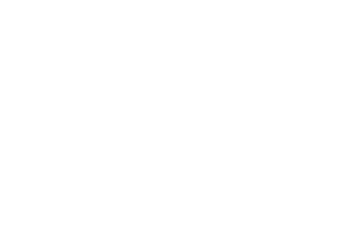

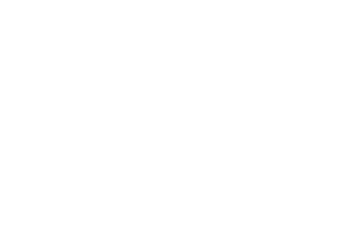

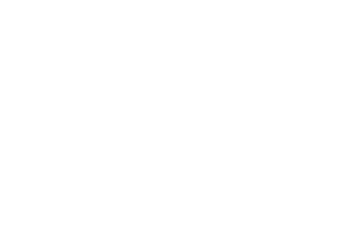

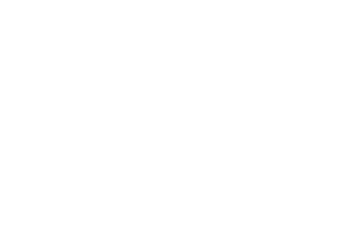

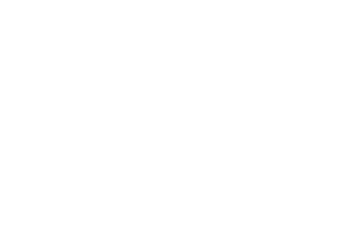

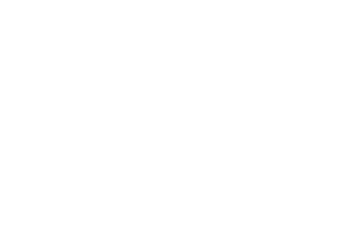

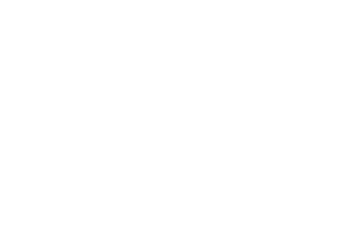

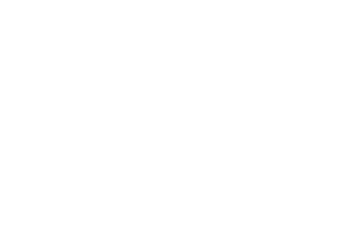

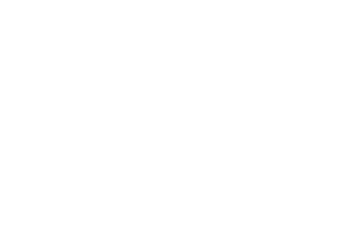

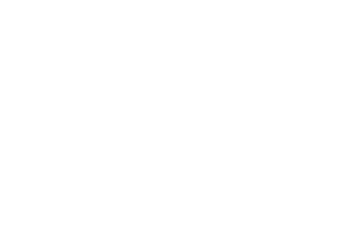

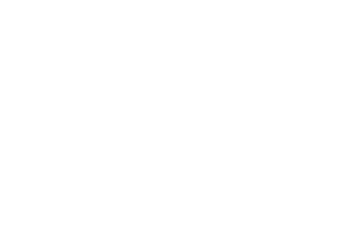

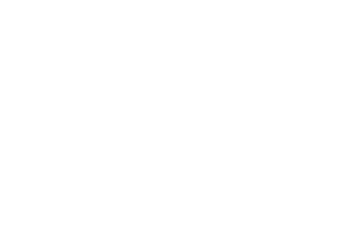

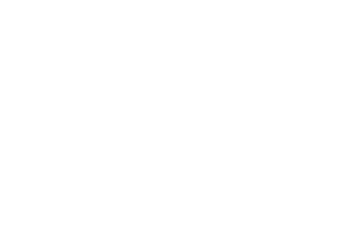

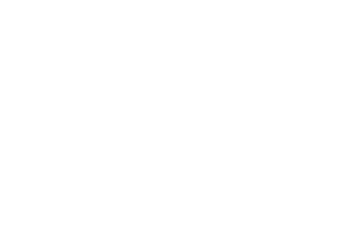

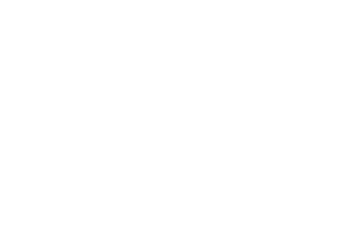

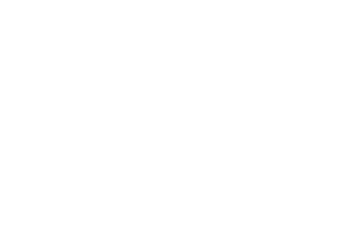

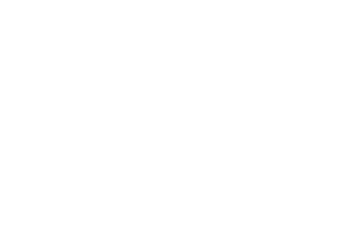

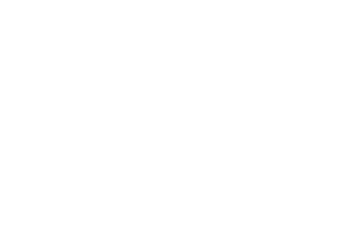

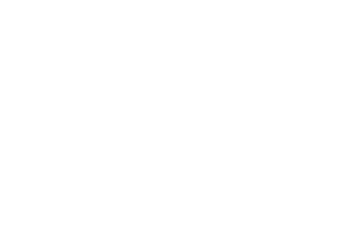

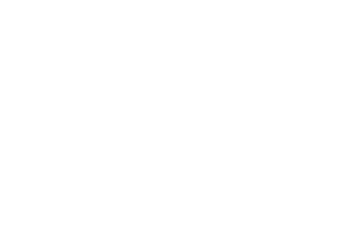

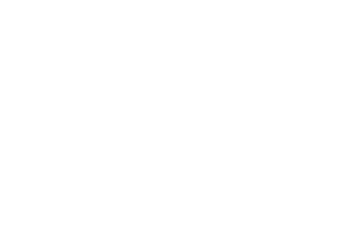

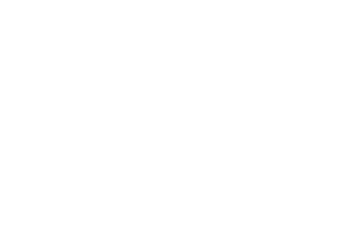

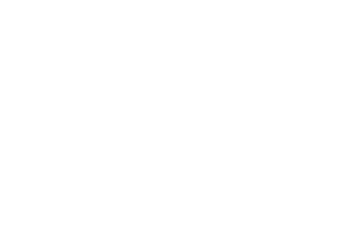

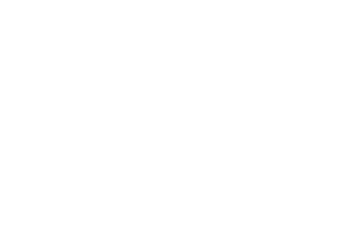

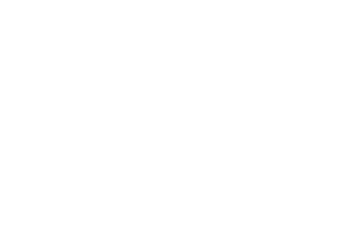

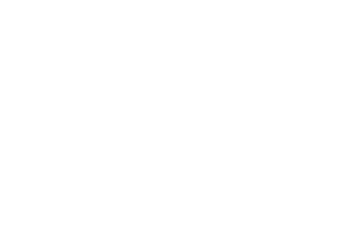

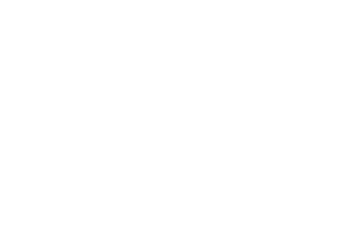

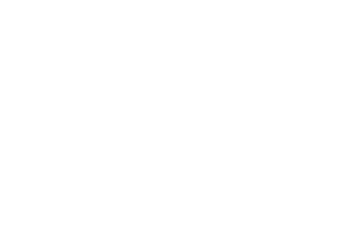

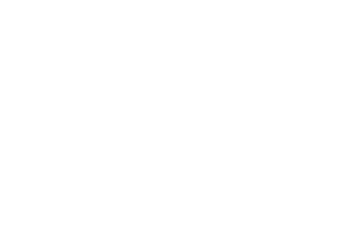

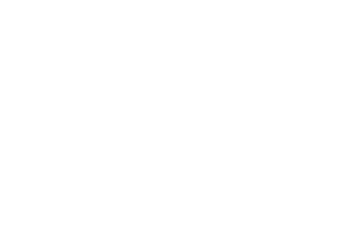

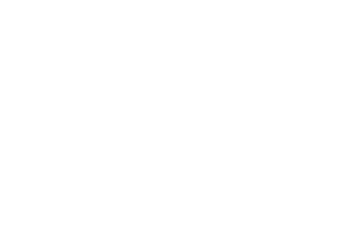

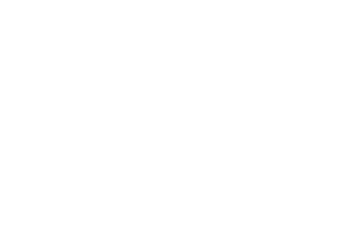

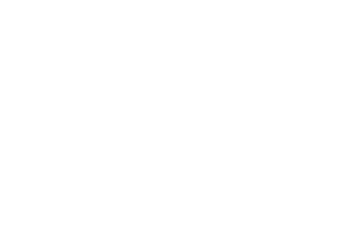

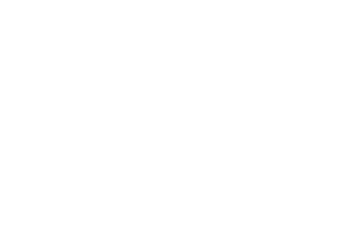

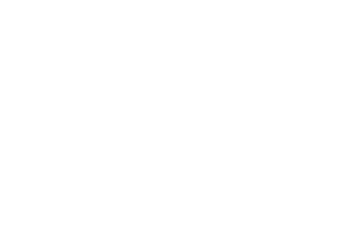

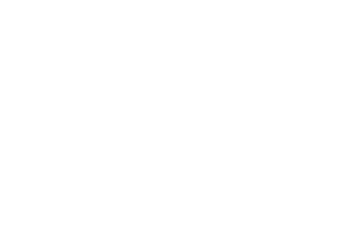

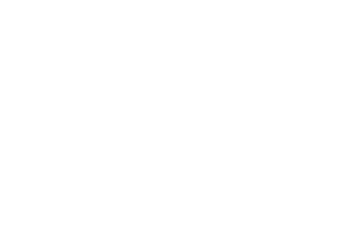

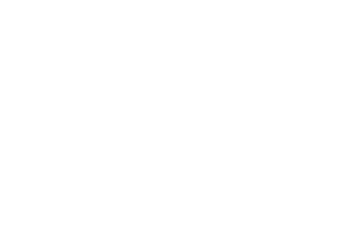

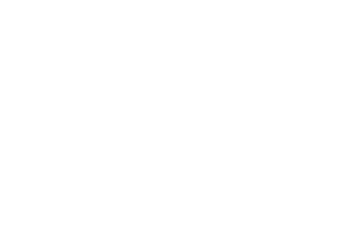

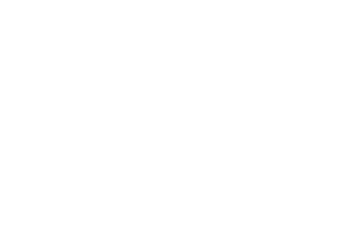

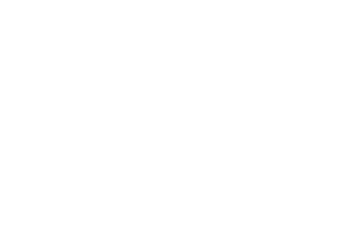

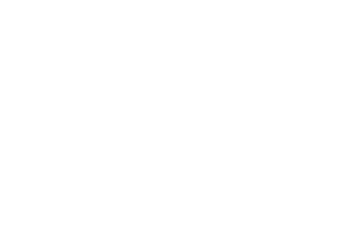

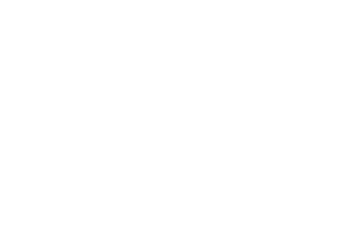

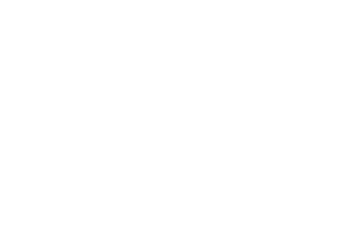

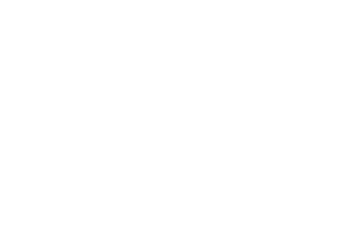

20:38:58.951 [INFO] (irl_trainer.py:119) Evaluation Total Steps:    4000 Average Reward -0.2000 / Average Step Count  10.2 over  5 episodes
20:38:58.958 [INFO] (irl_trainer.py:74) Total Epi:   423 Steps:    4001 Episode Steps:     7 Return: -1.0000 FPS:  1.53
20:38:59.095 [INFO] (irl_trainer.py:74) Total Epi:   424 Steps:    4010 Episode Steps:     9 Return: -1.0000 FPS: 66.48
20:38:59.308 [INFO] (irl_trainer.py:74) Total Epi:   425 Steps:    4025 Episode Steps:    15 Return:  1.0000 FPS: 70.91
20:38:59.536 [INFO] (irl_trainer.py:74) Total Epi:   426 Steps:    4040 Episode Steps:    15 Return:  1.0000 FPS: 66.41
20:38:59.699 [INFO] (irl_trainer.py:74) Total Epi:   427 Steps:    4051 Episode Steps:    11 Return:  1.0000 FPS: 68.03
20:38:59.845 [INFO] (irl_trainer.py:74) Total Epi:   428 Steps:    4061 Episode Steps:    10 Return: -1.0000 FPS: 69.19
20:39:00.074 [INFO] (irl_trainer.py:74) Total Epi:   429 Steps:    4077 Episode Steps:    16 Return:  1.0000 FPS: 70.23
20:39:00.277 [INFO] 

20:39:09.001 [INFO] (irl_trainer.py:74) Total Epi:   491 Steps:    4678 Episode Steps:     5 Return: -1.0000 FPS: 59.62
20:39:09.124 [INFO] (irl_trainer.py:74) Total Epi:   492 Steps:    4686 Episode Steps:     8 Return: -1.0000 FPS: 66.24
20:39:09.315 [INFO] (irl_trainer.py:74) Total Epi:   493 Steps:    4699 Episode Steps:    13 Return:  1.0000 FPS: 68.53
20:39:09.395 [INFO] (irl_trainer.py:74) Total Epi:   494 Steps:    4704 Episode Steps:     5 Return: -1.0000 FPS: 63.49
20:39:09.550 [INFO] (irl_trainer.py:74) Total Epi:   495 Steps:    4714 Episode Steps:    10 Return: -1.0000 FPS: 64.73
20:39:09.639 [INFO] (irl_trainer.py:74) Total Epi:   496 Steps:    4719 Episode Steps:     5 Return: -1.0000 FPS: 57.49
20:39:09.775 [INFO] (irl_trainer.py:74) Total Epi:   497 Steps:    4728 Episode Steps:     9 Return: -1.0000 FPS: 66.81
20:39:09.924 [INFO] (irl_trainer.py:74) Total Epi:   498 Steps:    4738 Episode Steps:    10 Return:  1.0000 FPS: 67.94
20:39:10.007 [INFO] (irl_trainer.py:74) 

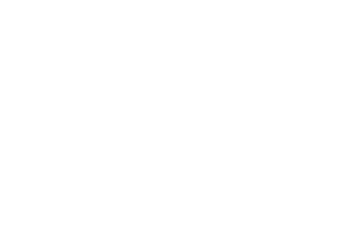

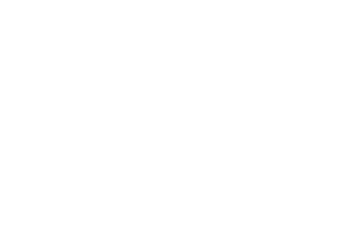

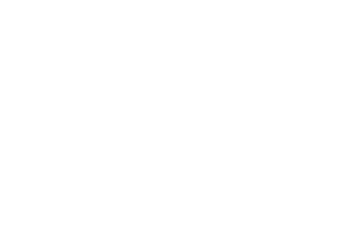

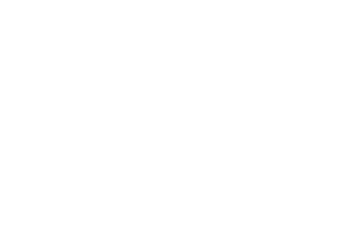

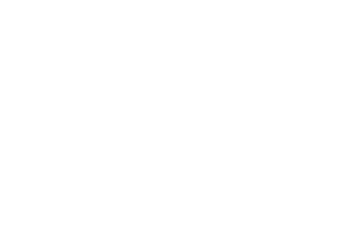

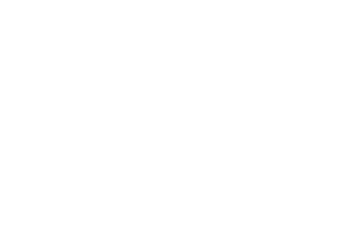

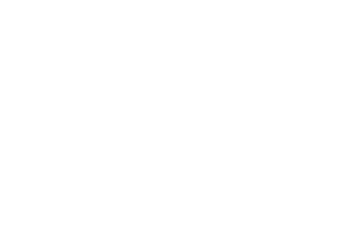

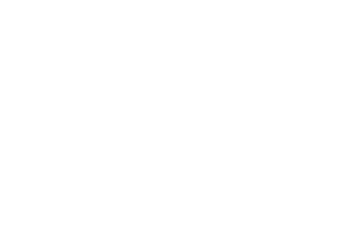

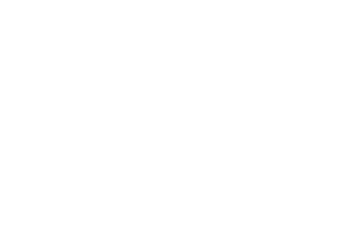

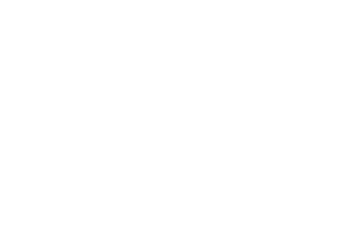

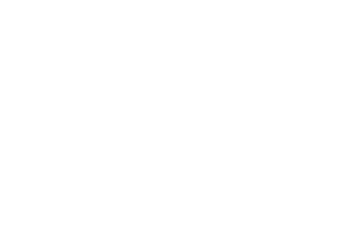

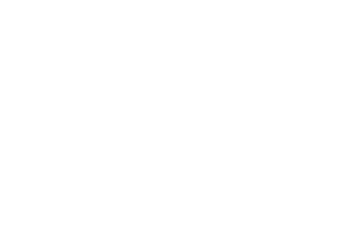

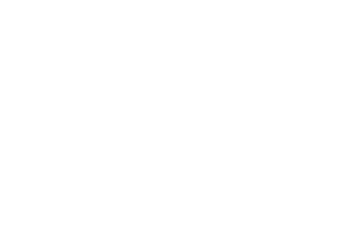

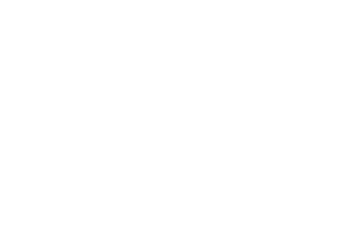

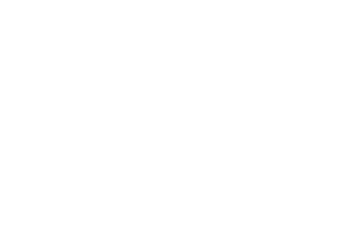

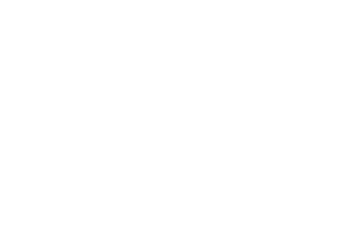

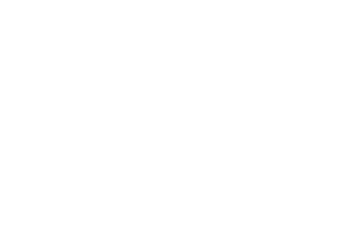

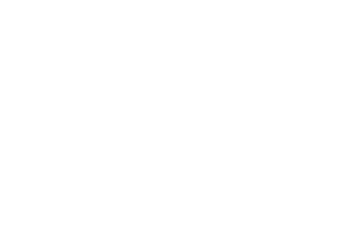

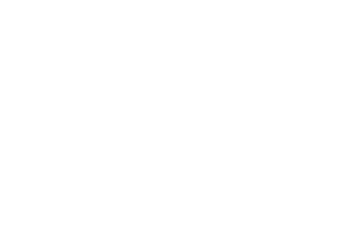

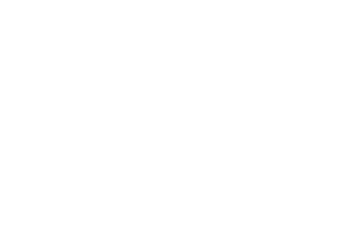

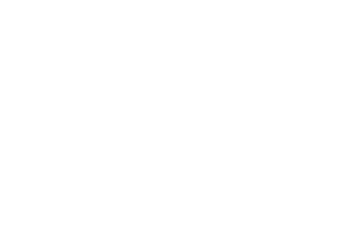

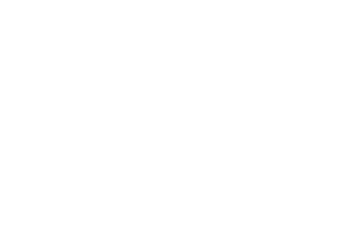

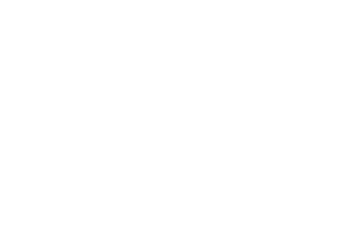

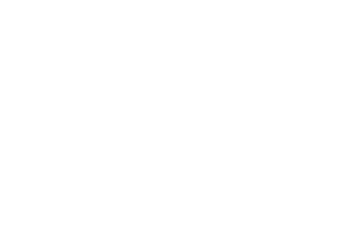

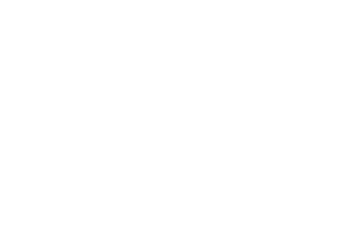

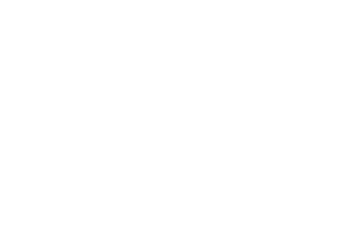

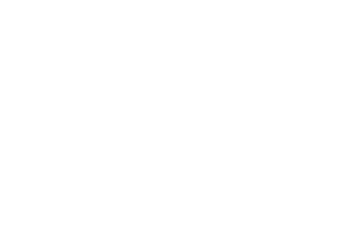

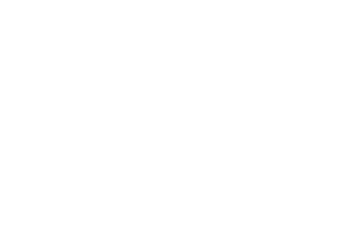

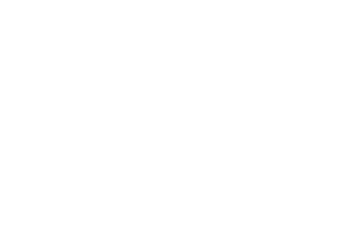

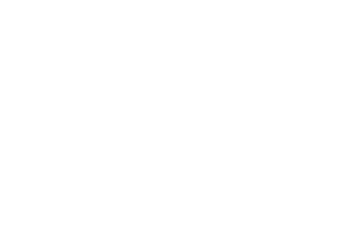

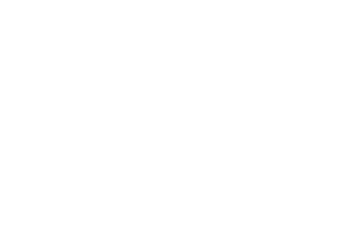

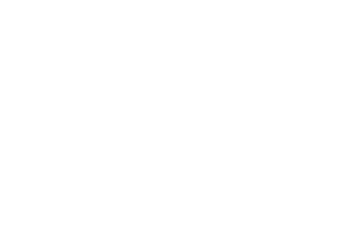

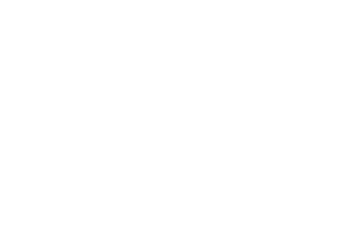

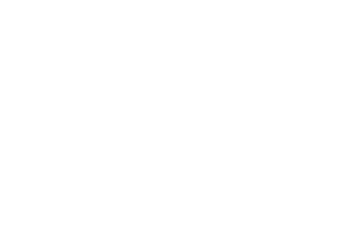

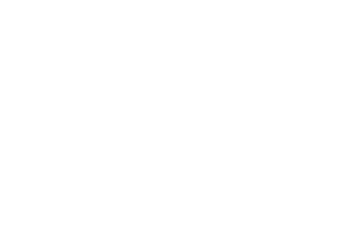

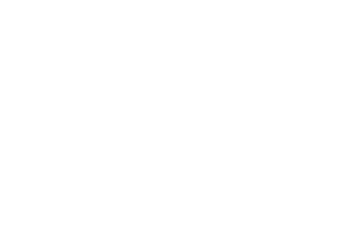

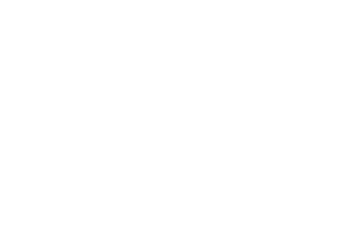

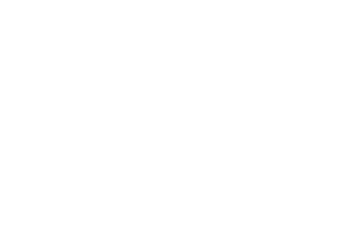

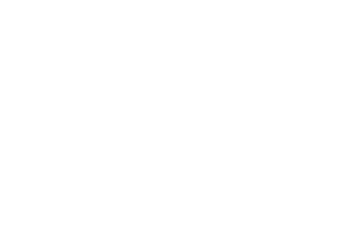

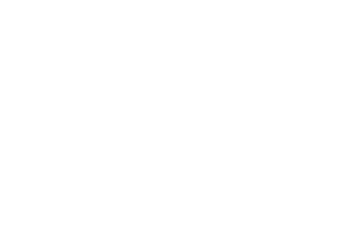

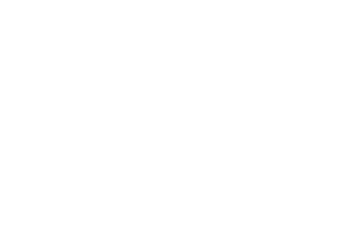

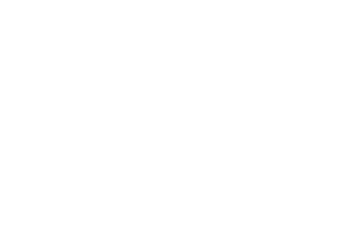

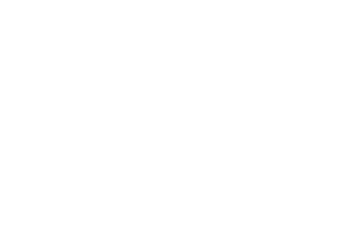

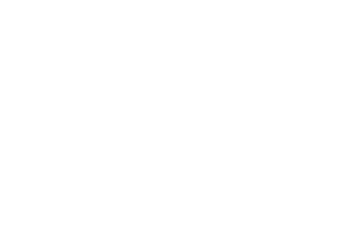

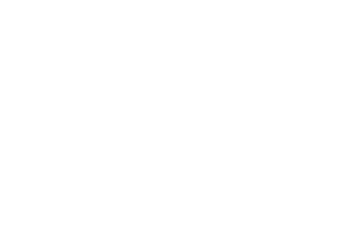

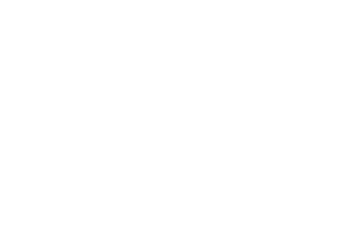

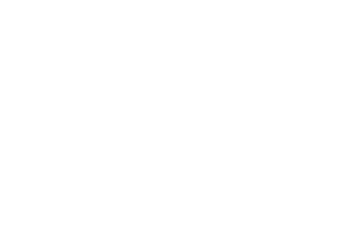

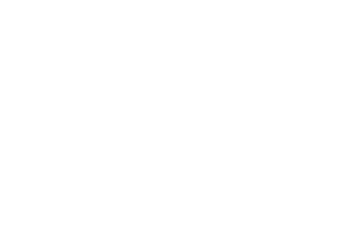

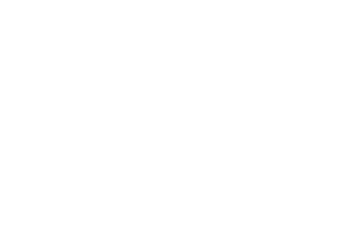

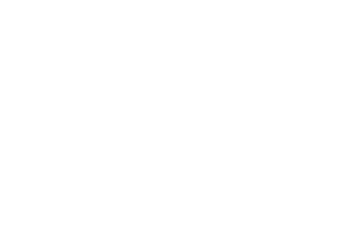

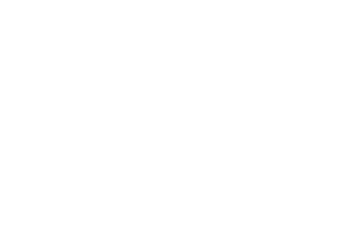

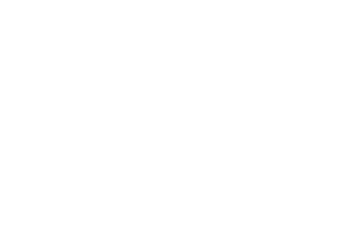

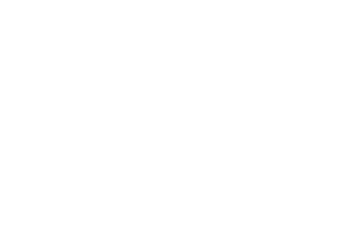

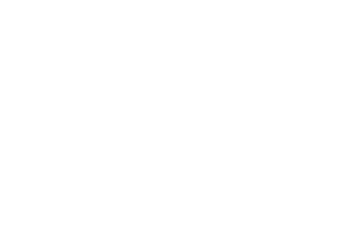

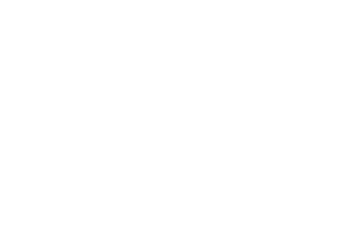

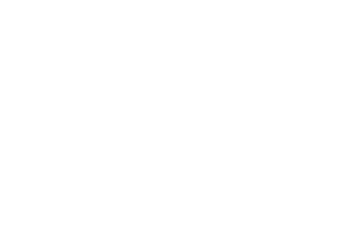

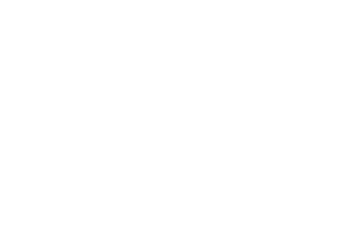

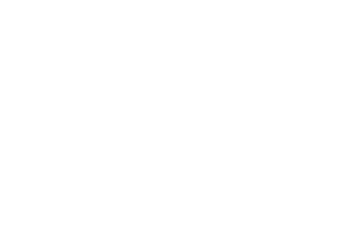

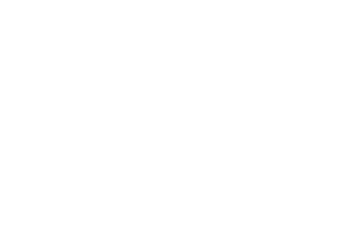

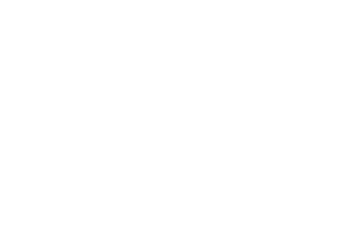

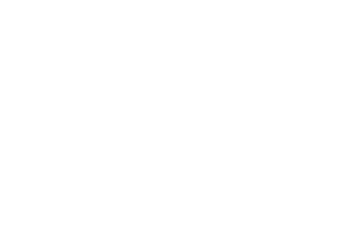

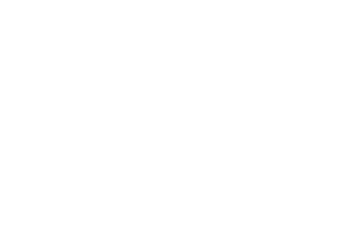

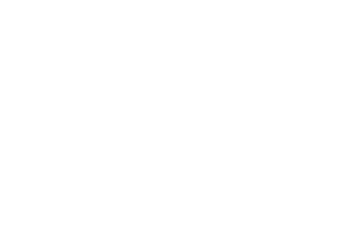

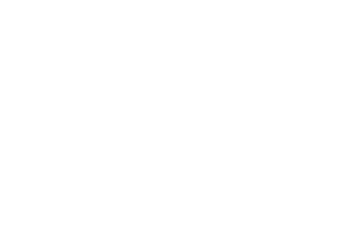

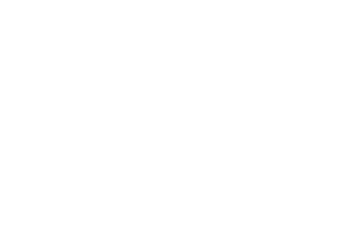

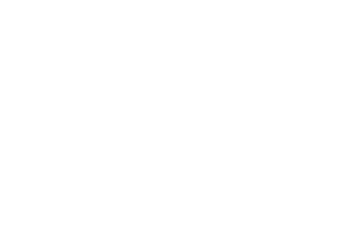

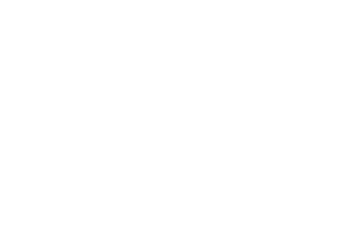

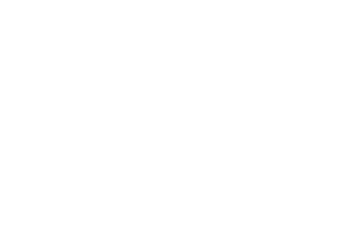

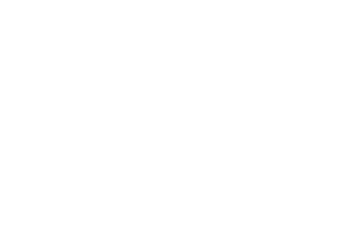

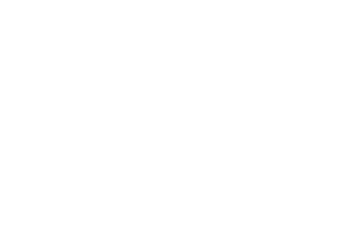

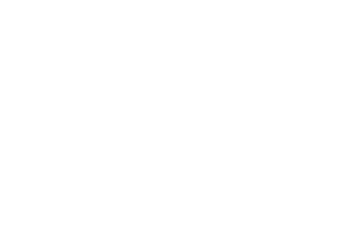

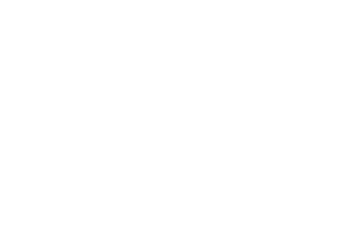

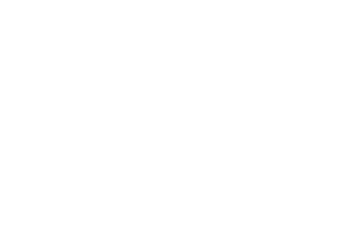

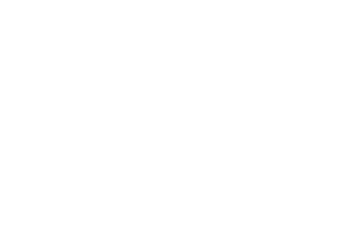

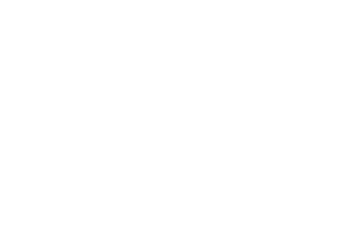

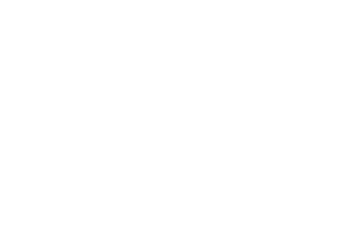

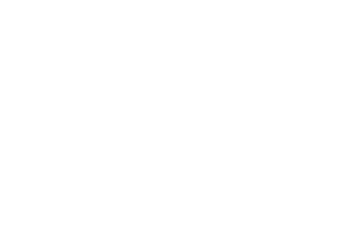

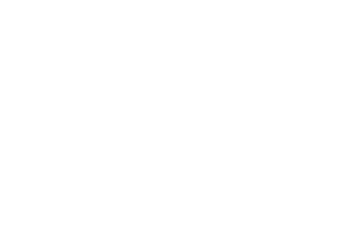

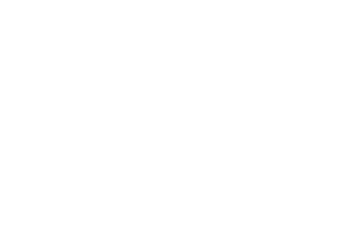

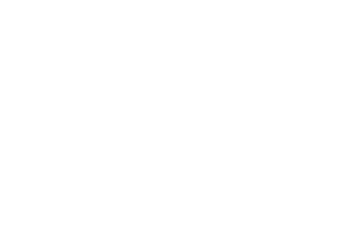

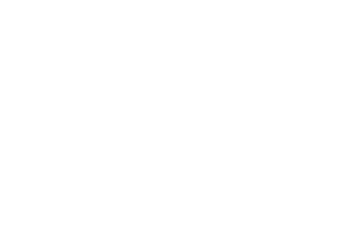

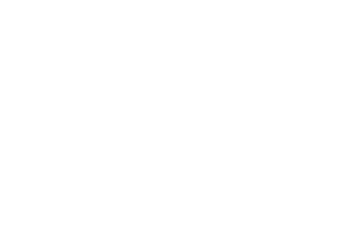

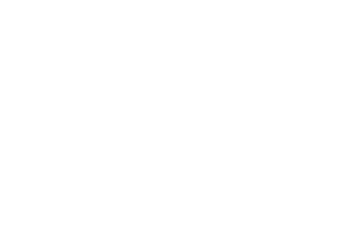

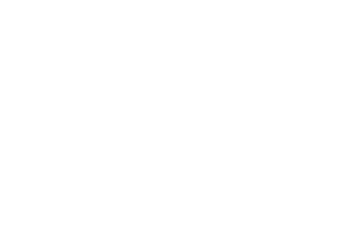

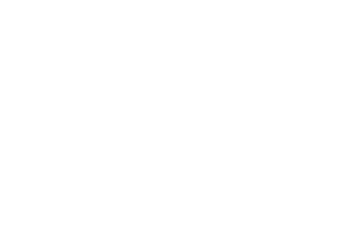

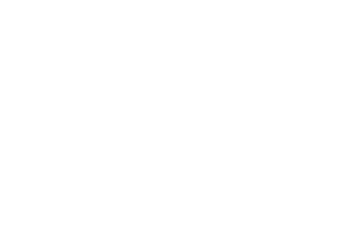

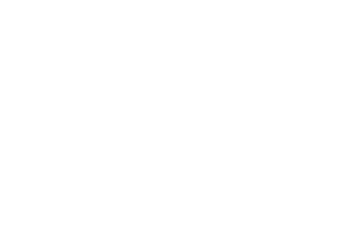

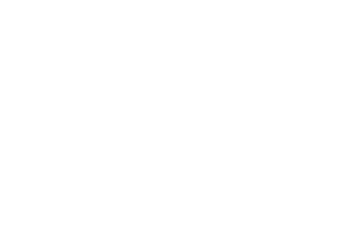

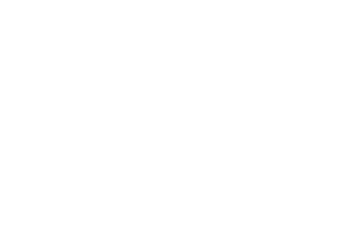

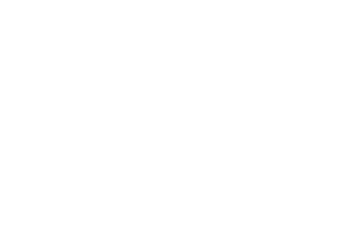

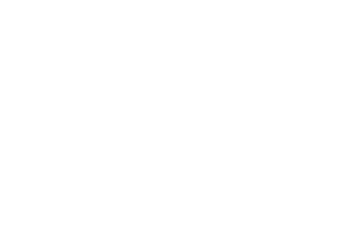

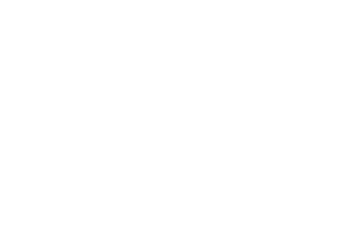

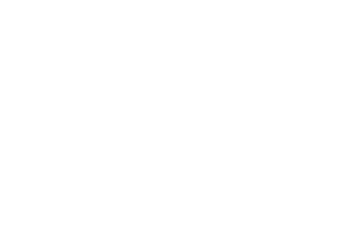

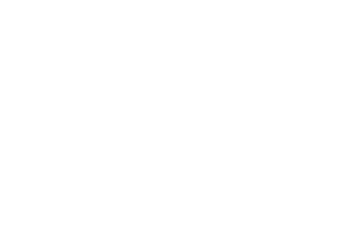

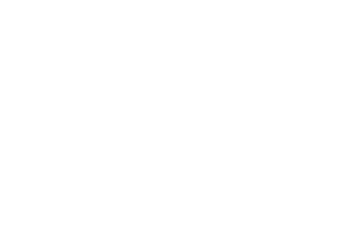

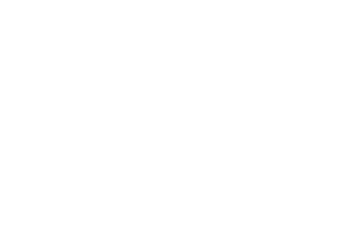

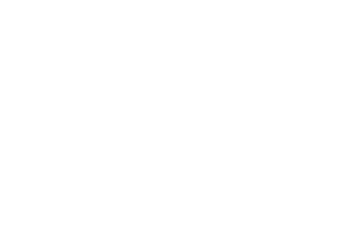

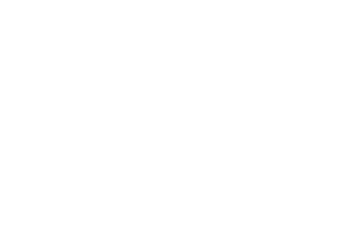

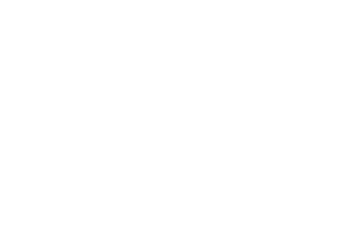

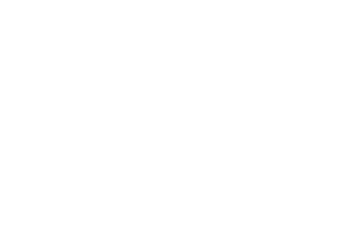

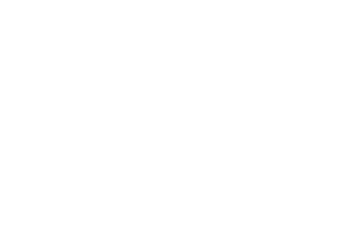

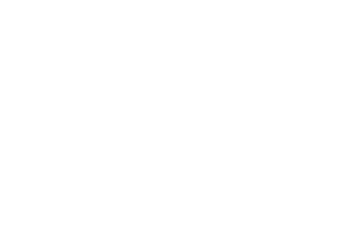

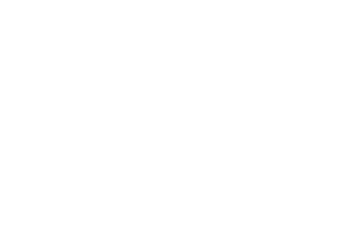

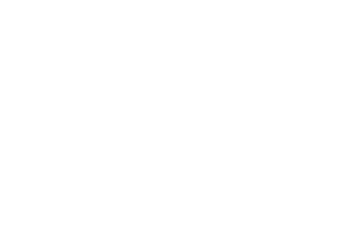

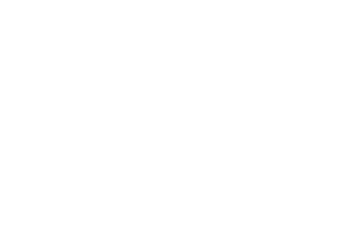

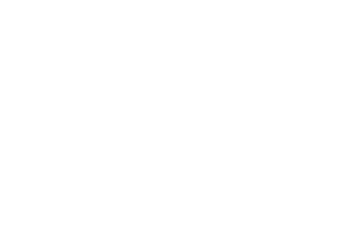

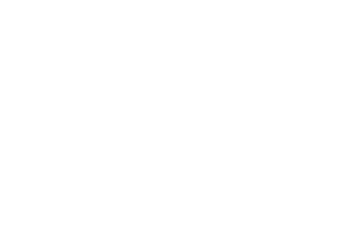

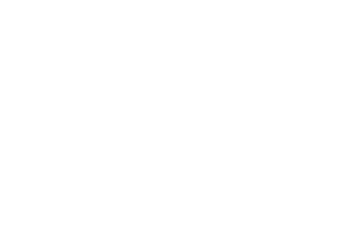

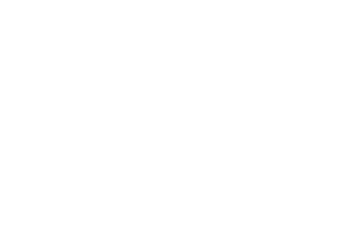

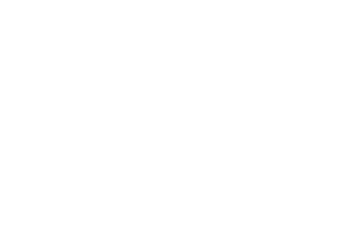

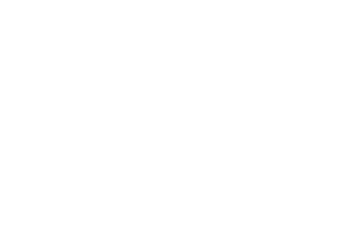

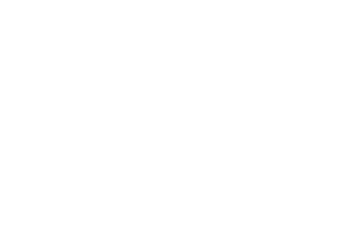

20:39:23.155 [INFO] (irl_trainer.py:119) Evaluation Total Steps:    5000 Average Reward  0.6000 / Average Step Count  22.4 over  5 episodes
20:39:23.176 [INFO] (irl_trainer.py:74) Total Epi:   522 Steps:    5002 Episode Steps:    17 Return:  1.0000 FPS:  1.76
20:39:23.463 [INFO] (irl_trainer.py:74) Total Epi:   523 Steps:    5022 Episode Steps:    20 Return:  1.0000 FPS: 70.03
20:39:23.678 [INFO] (irl_trainer.py:74) Total Epi:   524 Steps:    5037 Episode Steps:    15 Return: -1.0000 FPS: 70.20
20:39:24.055 [INFO] (irl_trainer.py:74) Total Epi:   525 Steps:    5064 Episode Steps:    27 Return:  1.0000 FPS: 72.01
20:39:24.217 [INFO] (irl_trainer.py:74) Total Epi:   526 Steps:    5075 Episode Steps:    11 Return:  1.0000 FPS: 68.57
20:39:24.282 [INFO] (irl_trainer.py:74) Total Epi:   527 Steps:    5079 Episode Steps:     4 Return: -1.0000 FPS: 63.15
20:39:24.474 [INFO] (irl_trainer.py:74) Total Epi:   528 Steps:    5092 Episode Steps:    13 Return:  1.0000 FPS: 68.55
20:39:24.672 [INFO] 

KeyboardInterrupt: 

In [3]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
params["ML"]["GAILRunner"]["tf2rl"]["max_steps"] = max_steps
params["ML"]["GAILRunner"]["tf2rl"]["test_interval"] = test_interval
params["ML"]["GAILRunner"]["tf2rl"]["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"]["show_test_progress"] = show_test_progress
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create some logging dirs if they are not present already
Path(params["ML"]["GAILRunner"]["tf2rl"]["logdir"]).mkdir(exist_ok=True, parents=True)
Path(params["ML"]["GAILRunner"]["tf2rl"]["model_dir"]).mkdir(exist_ok=True, parents=True)

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# load the expert trajectories
expert_trajectories = load_expert_trajectories(
    params["ML"]["GAILRunner"]["tf2rl"]["expert_path_dir"],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env # the unwrapped env has to be used, since that contains the unnormalized spaces.
    ) 

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# train the agent
runner.Train()

### Trained agent visualization:
Please set up the number of scenarios to visualize in the next cell!

In [4]:
# Number of scenarios to visualize:
num_scenarios_to_visualize = 10

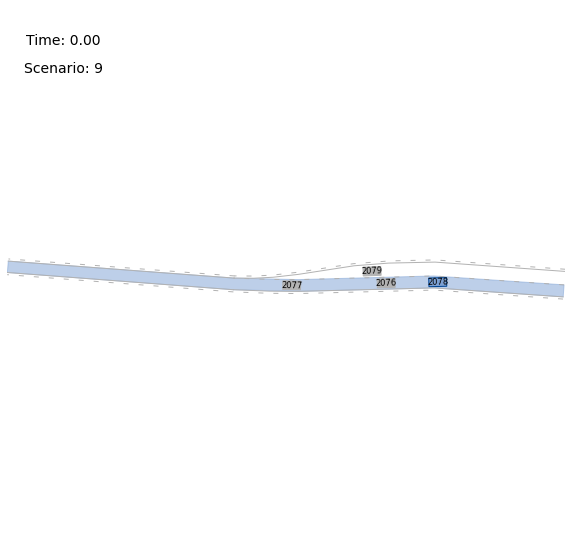

In [5]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# setting the path for the pretrained agent.
params["ML"]["GAILRunner"]["tf2rl"]["model_dir"] = os.path.join('data', 'pretrained_agent')

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
params["ML"]["GAILRunner"]["tf2rl"]["max_steps"] = max_steps
params["ML"]["GAILRunner"]["tf2rl"]["test_interval"] = test_interval
params["ML"]["GAILRunner"]["tf2rl"]["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"]["show_test_progress"] = show_test_progress
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create some logging dirs if they are not present already
Path(params["ML"]["GAILRunner"]["tf2rl"]["logdir"]).mkdir(exist_ok=True, parents=True)
Path(params["ML"]["GAILRunner"]["tf2rl"]["model_dir"]).mkdir(exist_ok=True, parents=True)

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# load the expert trajectories
expert_trajectories = load_expert_trajectories(
    params["ML"]["GAILRunner"]["tf2rl"]["expert_path_dir"],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env # the unwrapped env has to be used, since that contains the unnormalized spaces.
    ) 

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# Visualize the agent
runner.Visualize(num_scenarios_to_visualize, renderer="matplotlib_jupyter")

## Visual results

## Benchmark

## Summary

## Team